# Phase 4 Project

## Time Series Model

Let us start by loading the datasets and see what type of data we are dealing with

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import skew

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from colorama import Fore
from colorama import Style

plt.style.use('ggplot')

Let's load US energy generation

In [208]:
df = pd.read_csv('organised_Gen.csv',
                 parse_dates={ 'date': ['YEAR', 'MONTH'] })
df

date  Unnamed: 0 STATE                         TYPE OF PRODUCER  \
0      2001-01-01           0    AK            Total Electric Power Industry   
1      2001-01-01           1    AK            Total Electric Power Industry   
2      2001-01-01           2    AK            Total Electric Power Industry   
3      2001-01-01           3    AK            Total Electric Power Industry   
4      2001-01-01           4    AK            Total Electric Power Industry   
...           ...         ...   ...                                      ...   
496769 2022-05-01       10581    WY  Electric Generators, Electric Utilities   
496770 2022-05-01       10582    WY  Electric Generators, Electric Utilities   
496771 2022-05-01       10583    WY  Electric Generators, Electric Utilities   
496772 2022-05-01       10584    WY  Electric Generators, Electric Utilities   
496773 2022-05-01       10585    WY  Electric Generators, Electric Utilities   

                     ENERGY SOURCE  GENERATION (Megawatthours)  
0                             Coal                     46903.0  
1                        Petroleum                     71085.0  
2                      Natural Gas                    367521.0  
3       Hydroelectric Conventional                    104549.0  
4                             Wind                        87.0  
...                            ...                         ...  
496769                        Coal                   2071403.0  
496770  Hydroelectric Conventional                     96790.0  
496771                 Natural Gas                     91570.0  
496772                   Petroleum                      1812.0  
496773                        Wind                    452913.0  

[496774 rows x 6 columns]

## Data Preparation:

In [209]:
df.set_index('date', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df

STATE                         TYPE OF PRODUCER  \
date                                                        
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
...          ...                                      ...   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   

                         ENERGY SOURCE  GENERATION (Megawatthours)  
date                                                                
2001-01-01                        Coal                     46903.0  
2001-01-01                   Petroleum                     71085.0  
2001-01-01                 Natural Gas                    367521.0  
2001-01-01  Hydroelectric Conventional                    104549.0  
2001-01-01                        Wind                        87.0  
...                                ...                         ...  
2022-05-01                        Coal                   2071403.0  
2022-05-01  Hydroelectric Conventional                     96790.0  
2022-05-01                 Natural Gas                     91570.0  
2022-05-01                   Petroleum                      1812.0  
2022-05-01                        Wind                    452913.0  

[496774 rows x 4 columns]

In [210]:
df.isna().sum()

STATE                         0
TYPE OF PRODUCER              0
ENERGY SOURCE                 0
GENERATION (Megawatthours)    0
dtype: int64

In [211]:
df.describe()

GENERATION (Megawatthours)
count                4.967740e+05
mean                 1.393384e+06
std                  1.078685e+07
min                 -9.978550e+05
25%                  1.643000e+03
50%                  2.330103e+04
75%                  2.792042e+05
max                  4.217967e+08

Very interesting! Could pick a couple of energy sources and analyze them in parallel

In [212]:
df['ENERGY SOURCE'].value_counts()

Total                             73356
Natural Gas                       66684
Petroleum                         63176
Coal                              47642
Other Biomass                     46148
Hydroelectric Conventional        38842
Other                             36241
Wood and Wood Derived Fuels       30524
Wind                              25421
Solar Thermal and Photovoltaic    19393
Other Gases                       18212
Nuclear                           16754
Pumped Storage                    10139
Geothermal                         4242
Name: ENERGY SOURCE, dtype: int64

In [213]:
df['TYPE OF PRODUCER'].value_counts()

Total Electric Power Industry                       134452
Electric Generators, Electric Utilities              93792
Electric Generators, Independent Power Producers     89439
Combined Heat and Power, Industrial Power            77804
Combined Heat and Power, Commercial Power            53928
Combined Heat and Power, Electric Power              47359
Name: TYPE OF PRODUCER, dtype: int64

In [214]:
US_total=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']
US_total=US_total.loc[US_total['STATE']=='US-TOTAL']

In [215]:
US_total

STATE               TYPE OF PRODUCER  \
date                                                  
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
...              ...                            ...   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   

                             ENERGY SOURCE  GENERATION (Megawatthours)  
date                                                                    
2001-01-01                            Coal                 177287111.0  
2001-01-01                       Petroleum                  18111843.0  
2001-01-01                     Natural Gas                  42388663.0  
2001-01-01                     Other Gases                    718442.0  
2001-01-01                         Nuclear                  68707077.0  
...                                    ...                         ...  
2022-05-01                       Petroleum                   1524488.0  
2022-05-01  Solar Thermal and Photovoltaic                  15151118.0  
2022-05-01                   Other Biomass                   1440366.0  
2022-05-01                            Wind                  41891907.0  
2022-05-01     Wood and Wood Derived Fuels                   3073482.0  

[3598 rows x 4 columns]

In [216]:
US_total['ENERGY SOURCE'].value_counts()

Other Biomass                     257
Nuclear                           257
Solar Thermal and Photovoltaic    257
Geothermal                        257
Other                             257
Wood and Wood Derived Fuels       257
Hydroelectric Conventional        257
Petroleum                         257
Other Gases                       257
Total                             257
Coal                              257
Natural Gas                       257
Pumped Storage                    257
Wind                              257
Name: ENERGY SOURCE, dtype: int64

#### Changing Scale
GIven the high values for the column 'Generation (Megawatthours)' once we take the totals, we will convert the units to Terawatts per hour, where TWh=MWh*10^6.

In [217]:
US_total["Generation (TWh)"]=US_total["GENERATION (Megawatthours)"]/1000000
US_total.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)
US_total

STATE               TYPE OF PRODUCER  \
date                                                  
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
...              ...                            ...   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   

                             ENERGY SOURCE  Generation (TWh)  
date                                                          
2001-01-01                            Coal        177.287111  
2001-01-01                       Petroleum         18.111843  
2001-01-01                     Natural Gas         42.388663  
2001-01-01                     Other Gases          0.718442  
2001-01-01                         Nuclear         68.707077  
...                                    ...               ...  
2022-05-01                       Petroleum          1.524488  
2022-05-01  Solar Thermal and Photovoltaic         15.151118  
2022-05-01                   Other Biomass          1.440366  
2022-05-01                            Wind         41.891907  
2022-05-01     Wood and Wood Derived Fuels          3.073482  

[3598 rows x 4 columns]

In [218]:
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

In [219]:
US_source=US_source[(US_source['ENERGY SOURCE']!='Total')]

### Previewing the data by energy source

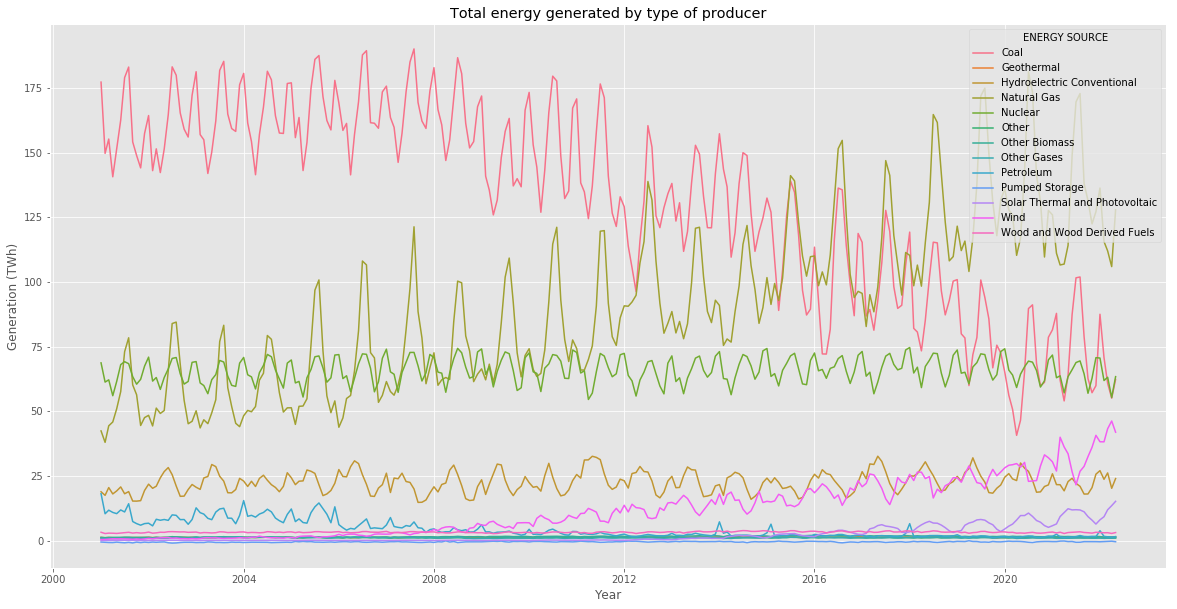

In [220]:
plt.figure(figsize=(20,10))
#Seaborn style
sns.color_palette("tab10")
#Plot - using mdates for correct datetime format
sns.lineplot(data=US_source, x=US_source['date'] ,y=US_source['Generation (TWh)'],hue="ENERGY SOURCE")
#Plot additional properties
#plt.grid()
#plt.xticks([str(i+2001)+"-01-01" for i in range(22)])
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()


Let us divide up the energy sources to be able to better see form the graphs their trends.

In [221]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]

In [222]:
US_top3

date ENERGY SOURCE  Generation (TWh)
0    2001-01-01          Coal        177.287111
3    2001-01-01   Natural Gas         42.388663
4    2001-01-01       Nuclear         68.707077
14   2001-02-01          Coal        149.735484
17   2001-02-01   Natural Gas         37.966927
...         ...           ...               ...
3573 2022-04-01   Natural Gas        105.934050
3574 2022-04-01       Nuclear         55.289540
3584 2022-05-01          Coal         62.288238
3587 2022-05-01   Natural Gas        127.926186
3588 2022-05-01       Nuclear         63.381624

[771 rows x 3 columns]

### Top 3: Coal, Natural Gas and  Nuclear

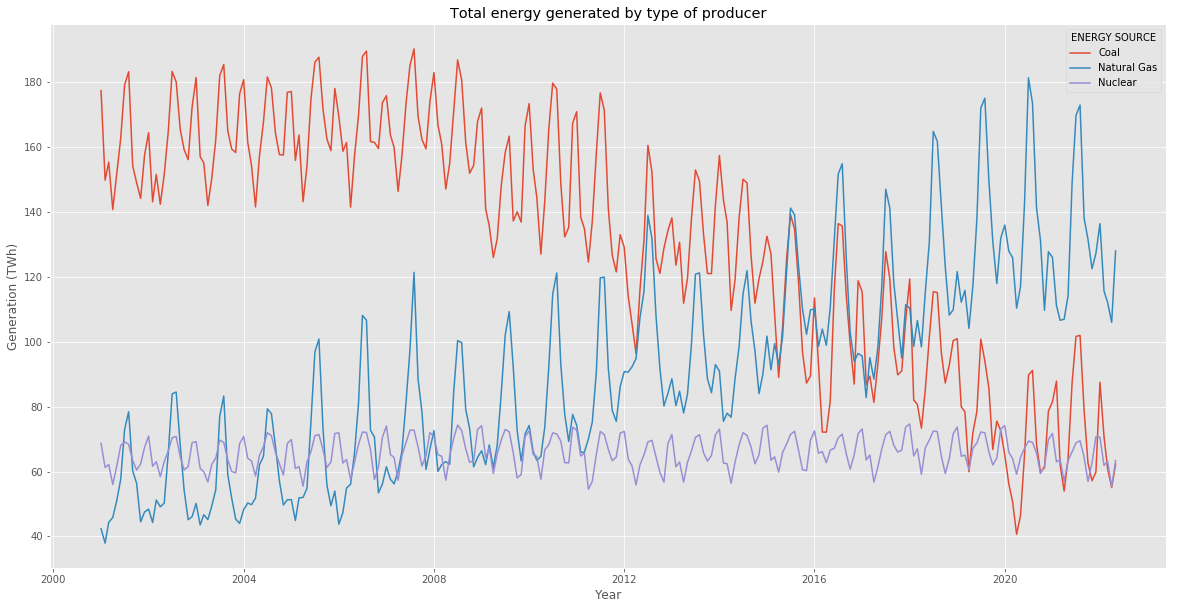

In [223]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['date'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()


### Next 4: Wind, Hydroelectric, Solar and Oil

In [224]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

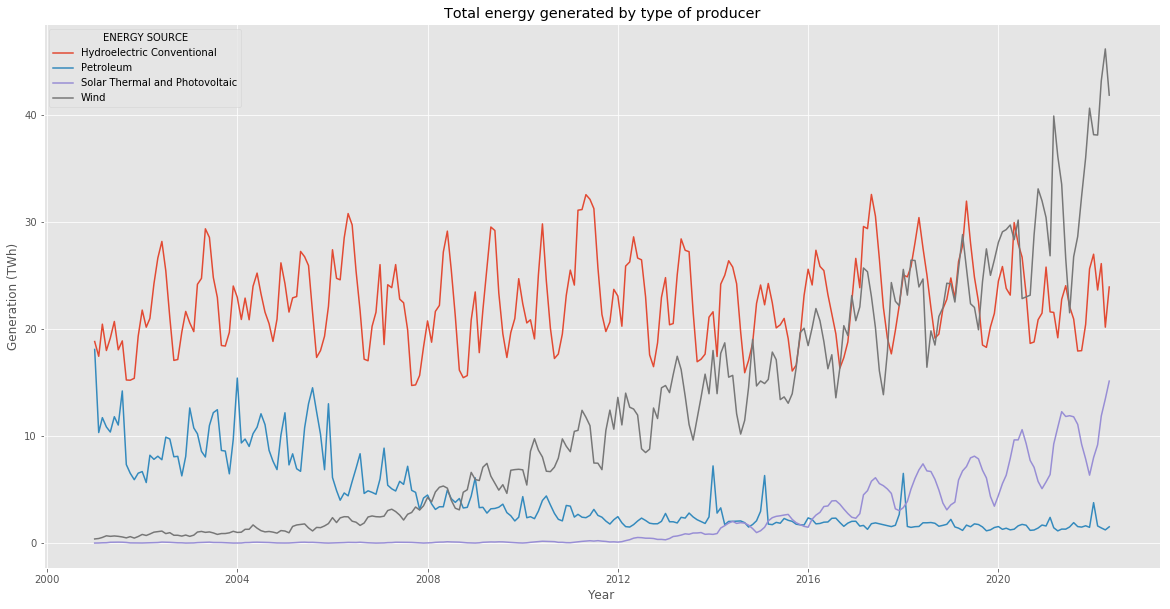

In [225]:
plt.figure(figsize=(20,10))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['date'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()

### Bottom of the pack:

In [226]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

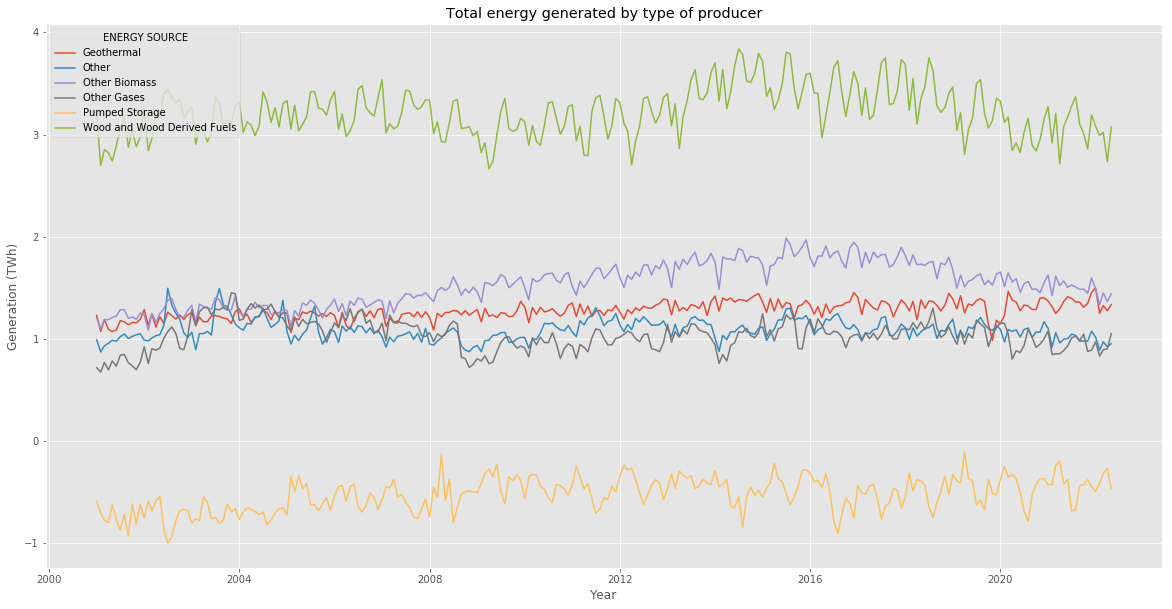

In [227]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_bot, x=US_bot['date'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()

### The three most growing ones: Natural Gas, Solar and Wind

The trends that have shown to be more interesting, with an upward trend over time are:
 Natural Gas, Wind and Solar. So let us preview those.

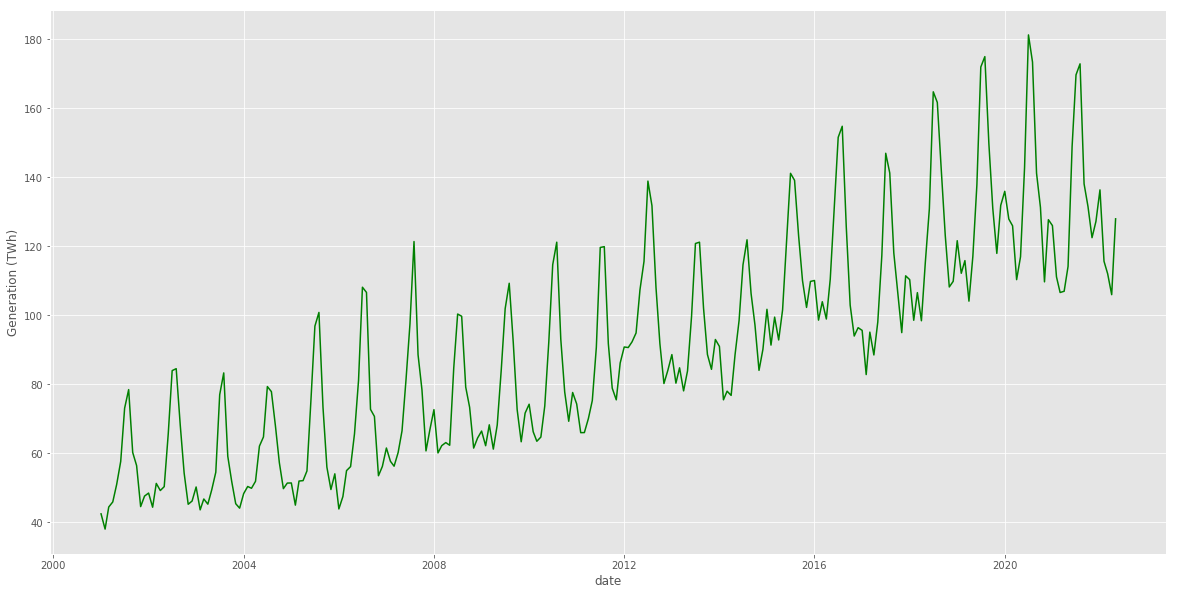

In [228]:
plt.figure(figsize=(20,10))
US_nat=US_total.loc[US_total['ENERGY SOURCE']=='Natural Gas']
sns.lineplot(x=US_nat.index, y=US_nat['Generation (TWh)'], color='green');

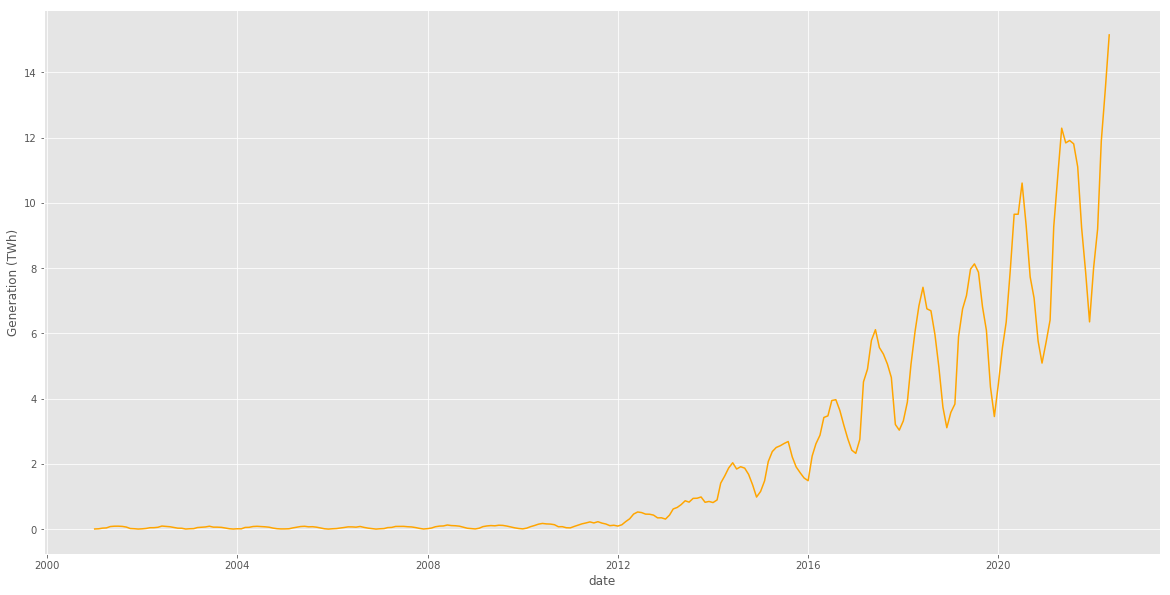

In [229]:
plt.figure(figsize=(20,10))
US_sol=US_total.loc[US_total['ENERGY SOURCE']=='Solar Thermal and Photovoltaic']
sns.lineplot(x=US_sol.index, y=US_sol['Generation (TWh)'], color='orange');

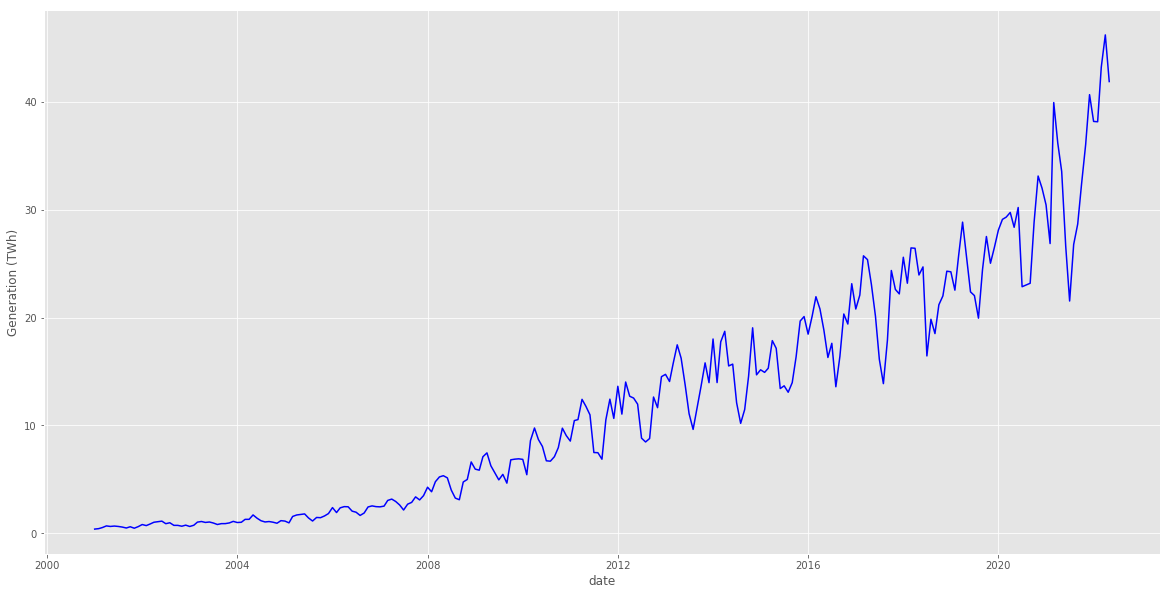

In [230]:
plt.figure(figsize=(20,10))
US_wind=US_total.loc[US_total['ENERGY SOURCE']=='Wind']
sns.lineplot(x=US_wind.index,y=US_wind['Generation (TWh)'], color='blue');

## Checking for Normality, skewness and kurtosis

#### Natural Gas:

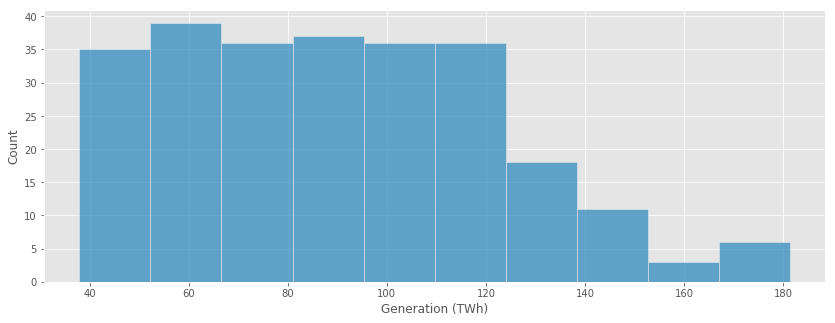

In [231]:
sns.histplot(US_nat['Generation (TWh)']);

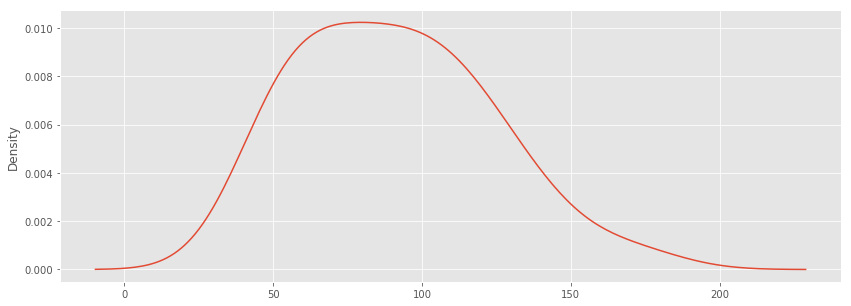

In [232]:
sns.kdeplot(np.array(US_nat['Generation (TWh)']), bw=0.5);

There is clearly a skew in the data because the lowest value of production we have, around 2001, is around 40 TWh, it does not start at zero. Let us use our tools from SciPy to get actual values for normality, skewness and kurtosis.

In [233]:
k2, p = stats.normaltest(US_nat['Generation (TWh)'])
kur = kurtosis(US_nat['Generation (TWh)'], fisher=True)
sk=skew(US_nat['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:0.003959050613625347
The value for kurtosis for this sample is: -0.35228324109119846
The value of skewness for this sample is:0.4830844892501781


The null hypothesis for the normal test is that the sample comes from a normal distribution.
<br>In our case with a standard alpha of 0.05 we can say that we can reject the null hypothesis and say that our sample is not normally distributed.
<br>With Fisher's definition of kurtosis normal=0 so we are pretty close to normality in terms of kurtosis.
<br>The value of 0.48 for skew indicates that our distribution is moderately skewed, as we could infer from looking at the graphs.

#### Solar

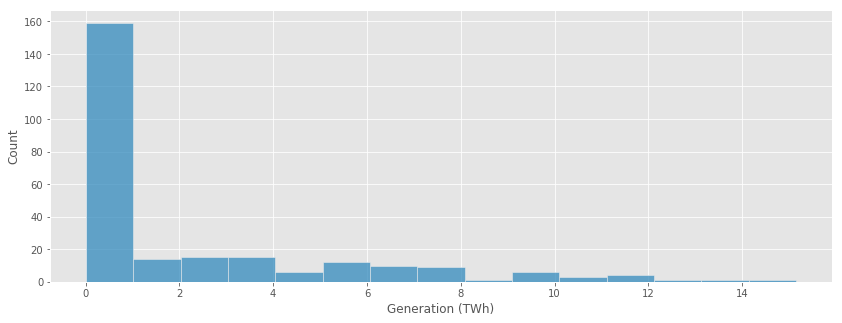

In [234]:
sns.histplot(US_sol['Generation (TWh)']);

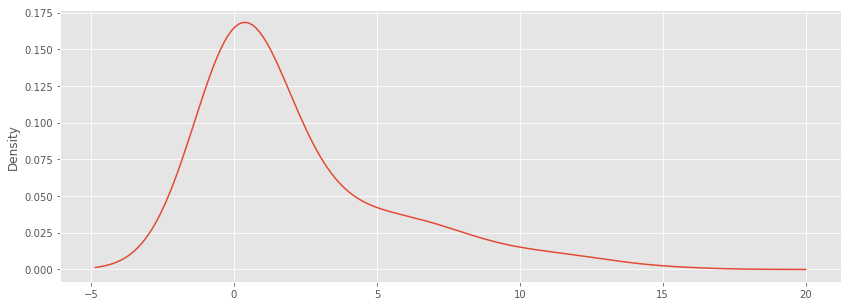

In [235]:
sns.kdeplot(np.array(US_sol['Generation (TWh)']), bw=0.5);

In [236]:
k2, p = stats.normaltest(US_sol['Generation (TWh)'])
kur = kurtosis(US_sol['Generation (TWh)'], fisher=True)
sk=skew(US_sol['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:6.333758801915125e-19
The value for kurtosis for this sample is: 2.135719804718372
The value of skewness for this sample is:1.6823253826109177


In the case of solar energy also we can reject the null hypothesis and say that our sample is not normally distributed.
<br>This sample shows a kurtosis higher than 2, which also takes our sample outside of normality.
<br>The value of 1.68 for skew indicates that our distribution is skewed, but still acceptable in the range for normality.

#### Wind

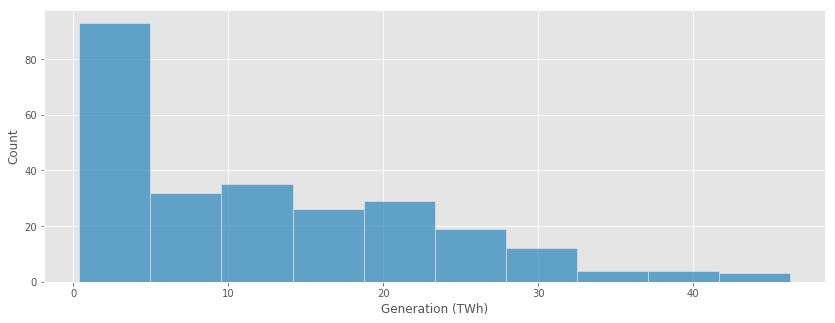

In [237]:
sns.histplot(US_wind['Generation (TWh)']);

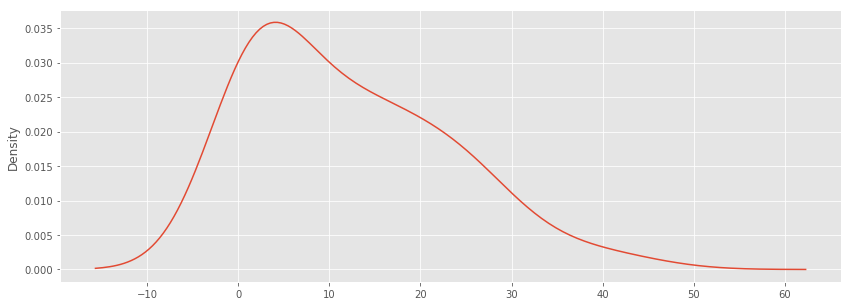

In [238]:
sns.kdeplot(np.array(US_wind['Generation (TWh)']), bw=0.5);

In [239]:
k2, p = stats.normaltest(US_wind['Generation (TWh)'])
kur = kurtosis(US_wind['Generation (TWh)'], fisher=True)
sk=skew(US_wind['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:1.2775838040979476e-05
The value for kurtosis for this sample is: -0.14672678485081514
The value of skewness for this sample is:0.7875242470552442


For our sample of energy generated by wind we can reject the null hypothesis and say that our sample is not normally distributed.
<br>This sample shows a kurtosis of -0.14 which means the curve is too flat to be normal, but still pretty close to the zero of normality.
<br>The value of 0.78 for skew indicates that our distribution is skewed, but not very far from the range for normality.

The ultimately deciding factor is the p value so we have to accept that all three of our samples are not normally distributed. <br>Given time series this is not a requirement for our data, but this study let us understand more the characteristic of the samples we working with.

## Split Train Validation and Test set

Now that we have decided what sources we are going to work on, we are going to perform a train-validation-test split so that the models we are going to create, based only on the information we have from the train, do not suffer from data-leaking.
We will consequently test our models on the validation set, to choose the best performing model, and we will utimately test it on the test set, that in this way will represent datat that was not unseen for the model.
We will use this comparison with the test to get a sense of our margins of error, and then use our model to forecast for the next 3 years.

In [240]:
nat=US_nat['Generation (TWh)']
sol=US_sol['Generation (TWh)']
wind=US_wind['Generation (TWh)']

In [241]:
# Definig the 80% cutoff for the split train - validation&test
cutoff = round(nat.shape[0]*0.8)
cutoff

206

In [242]:
# Defining the two sets, train and test& validation based on the cutoff
train = nat[:(cutoff+1)] #the +1 is added to avoid gaps in the series

testval = nat[cutoff:]


In [243]:
testval.index[0]

Timestamp('2018-03-01 00:00:00')

From here we can see that having performed an 80/20 split for train and test we have the year from January 2018 on as part of the test.
We want to create a validation set form the test set, that is usually around 20% but since the test is composed of 4 years to keep things more tidy, and be able to capture seasonality better in our validation set, we are going to make it 25%, so to be a whole year.

In [244]:
cutoff2 = round(testval.shape[0]*0.25)
cutoff2

13

In [245]:
val = testval[:(cutoff2+1)]

test = testval[cutoff2:]

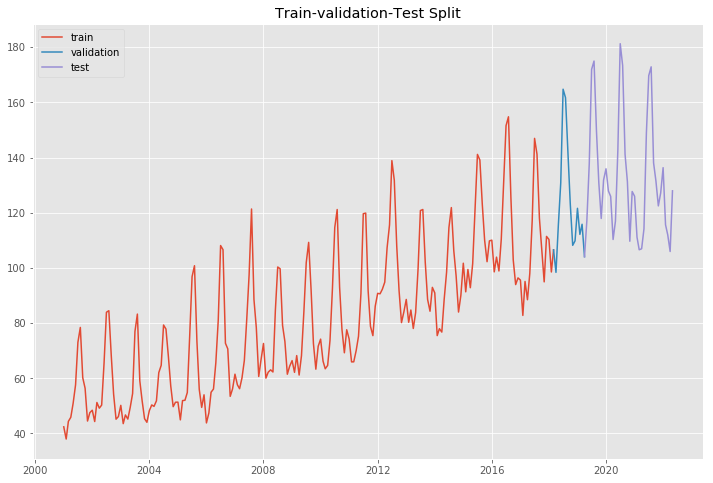

In [246]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(val, label='validation')
ax.plot(test, label='test')
ax.set_title('Train-validation-Test Split');
plt.legend();

In [247]:
test.index[0]

Timestamp('2019-04-01 00:00:00')

In [248]:
val.index[0]

Timestamp('2018-03-01 00:00:00')

In [249]:
train

date
2001-01-01     42.388663
2001-02-01     37.966927
2001-03-01     44.364414
2001-04-01     45.842746
2001-05-01     50.934205
                 ...    
2017-11-01     94.928341
2017-12-01    111.397792
2018-01-01    110.292909
2018-02-01     98.511852
2018-03-01    106.523780
Name: Generation (TWh), Length: 207, dtype: float64

In [250]:
val

date
2018-03-01    106.523780
2018-04-01     98.371080
2018-05-01    115.283982
2018-06-01    130.826400
2018-07-01    164.749060
2018-08-01    161.676241
2018-09-01    141.785528
2018-10-01    123.142239
2018-11-01    108.167635
2018-12-01    109.801976
2019-01-01    121.581777
2019-02-01    112.135473
2019-03-01    115.806072
2019-04-01    104.053161
Name: Generation (TWh), dtype: float64

In [251]:
test

date
2019-04-01    104.053161
2019-05-01    117.052615
2019-06-01    137.827808
2019-07-01    171.941961
2019-08-01    174.955372
2019-09-01    149.687661
2019-10-01    130.940660
2019-11-01    117.903947
2019-12-01    131.830286
2020-01-01    135.905175
2020-02-01    127.861217
2020-03-01    125.895408
2020-04-01    110.291535
2020-05-01    116.933505
2020-06-01    142.822497
2020-07-01    181.248097
2020-08-01    173.379404
2020-09-01    141.155144
2020-10-01    131.232950
2020-11-01    109.650802
2020-12-01    127.674265
2021-01-01    125.959747
2021-02-01    111.110664
2021-03-01    106.565144
2021-04-01    106.920249
2021-05-01    114.131496
2021-06-01    148.842629
2021-07-01    169.662613
2021-08-01    172.859149
2021-09-01    138.061580
2021-10-01    131.489744
2021-11-01    122.458121
2021-12-01    127.168673
2022-01-01    136.317103
2022-02-01    115.615259
2022-03-01    112.002542
2022-04-01    105.934050
2022-05-01    127.926186
Name: Generation (TWh), dtype: float64

So we can see that with our split, the train starts on January 2021 and end on March 2013, the validation set goes from March 2018 until April 2019 and the test holdout set is from April 2019 until May 2022.

### Subtracting Rolling Mean

In [252]:
roll_mean = train.rolling(window=12, center=False).mean()
roll_std = train.rolling(window=12, center=False).std()

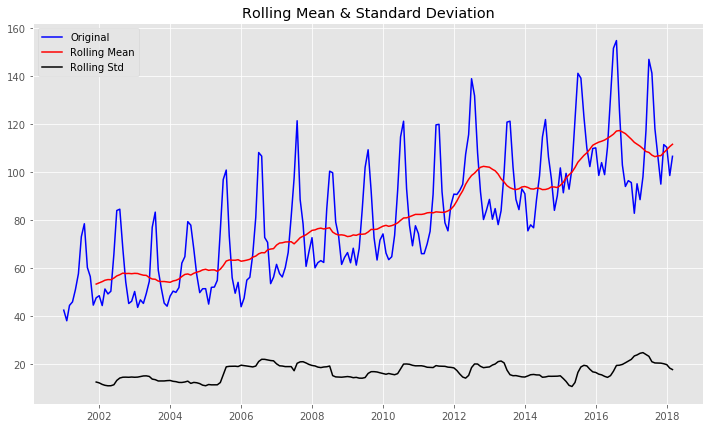

In [253]:
fig = plt.figure(figsize=(12,7))
plt.plot(train, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [254]:
dftest = adfuller(train)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-0.4857072897184561, 0.8947755741324734, 15, 191, {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}, 1250.5326958945707)


In [255]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -0.485707
p-value                          0.894776
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


The p values is clearly > 0.05, the series is not stationary as we could expect.

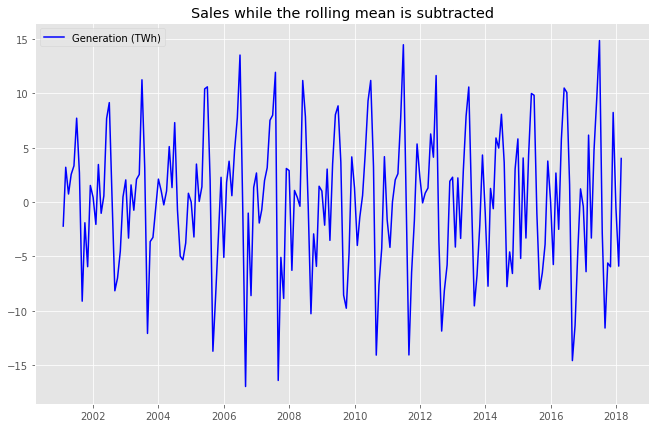

In [256]:
roll_mean_nat = train.rolling(window=2, center=False).mean()
# Subtract the moving average from the original data
data_mrm_nat = train - roll_mean_nat
# Drop the missing values from time series calculated above
data_mrm_nat.dropna(inplace=True)
# Plot sales with rolling mean subtracted
fig = plt.figure(figsize=(11,7))
plt.plot(data_mrm_nat, color='blue')#,label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show();#(block=False)

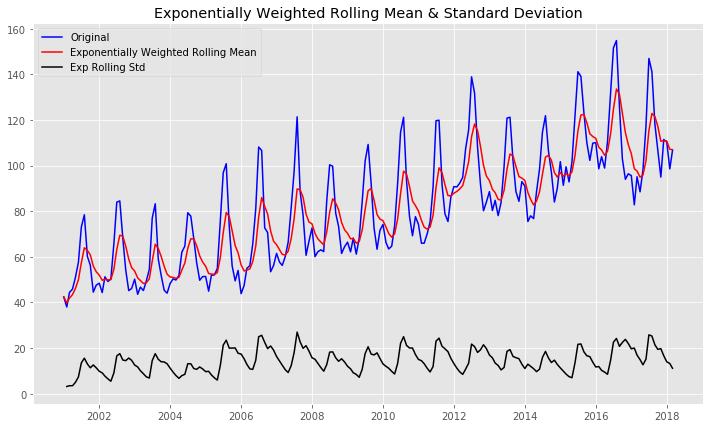

In [257]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = train.ewm(halflife=2).mean()
roll_std = train.ewm(halflife=2).std()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(train, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.plot(roll_std, color='black', label = 'Exp Rolling Std')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

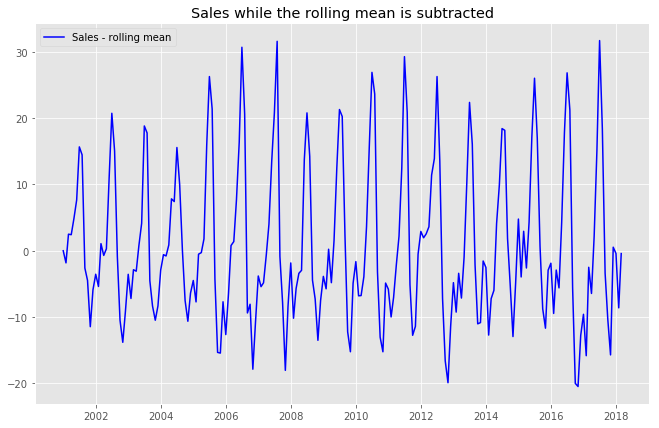

In [258]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = train - exp_roll_mean
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [259]:
dftest = adfuller(data_mrm_nat)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.202030
p-value                          0.000654
#Lags Used                      15.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


In [260]:
dftest = adfuller(data_minus_exp_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.697668
p-value                          0.000085
#Lags Used                      14.000000
Number of Observations Used    192.000000
Critical Value (1%)             -3.464875
Critical Value (5%)             -2.876714
Critical Value (10%)            -2.574859
dtype: float64


> Here maybe a paragraph in which you explain what it means, the fact that the residualas are stationary and why do we subract the rolling mean, because there is a dependence on the previous periods, specifically the amounts of periods specified in the window. And that expotential means the ones closer in time are more relevant then the others.

## Series Decomposition

**When log is better than natural, is because the trend is exponential (growth in our case) inste of linear growth.**

### Decomposing Natural Gas

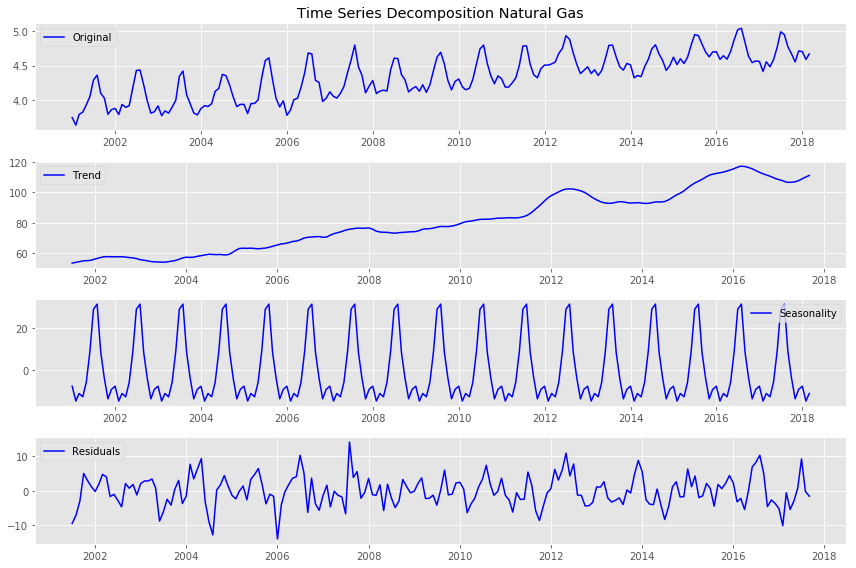

In [261]:
decomposition = seasonal_decompose(train)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

In [262]:
residual.dropna(inplace=True)

In [263]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.072536e+00
p-value                        1.141737e-07
#Lags Used                     1.500000e+01
Number of Observations Used    1.790000e+02
Critical Value (1%)           -3.467420e+00
Critical Value (5%)           -2.877826e+00
Critical Value (10%)          -2.575452e+00
dtype: float64


### Decomposing log(natural gas)

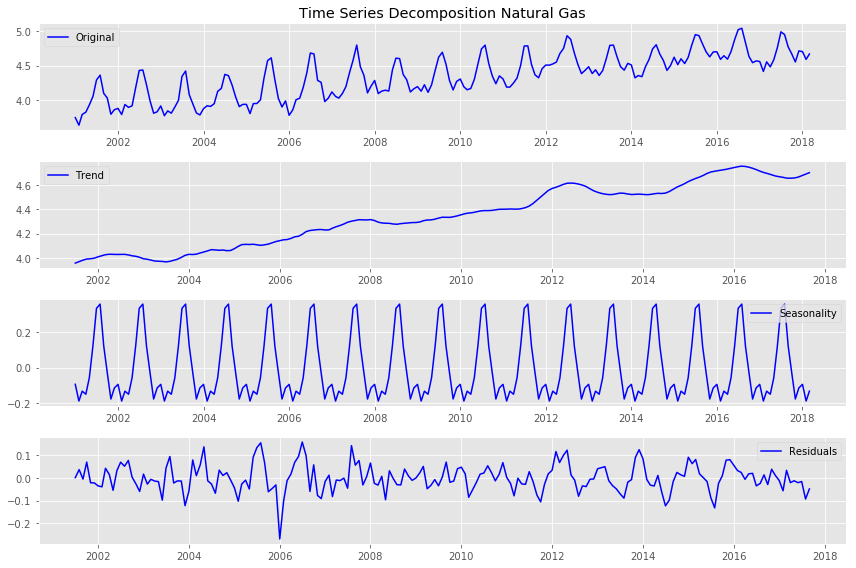

In [264]:
decomposition = seasonal_decompose(np.log(train))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

In [265]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.280252e+00
p-value                        4.540005e-13
#Lags Used                     8.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


## Multiplicative instead of additive models

Not getting better. Let's try multiplicative instead of additive. Back to the whole series, which performed better.

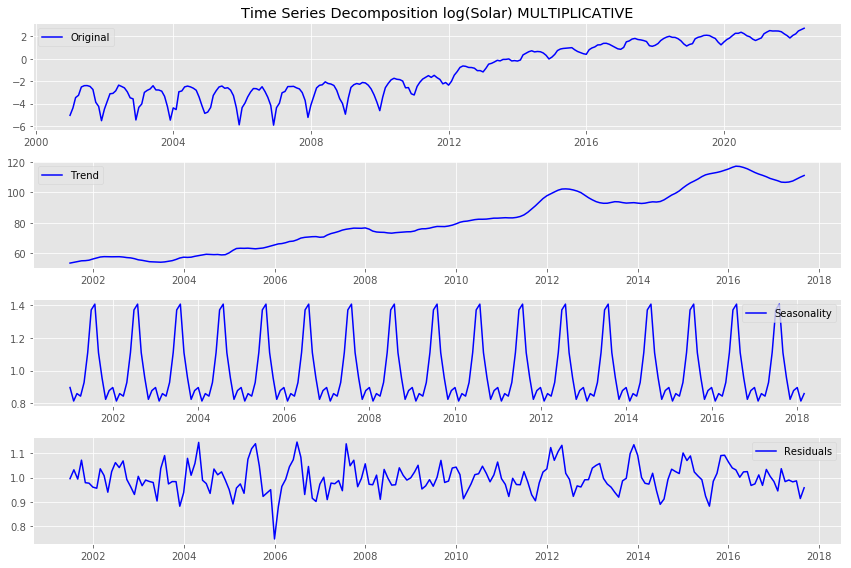

In [266]:
decomposition = seasonal_decompose(train, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition log(Solar) MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [267]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -5.519263
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


Much better!
Now out of curiosity let me try to do multiplicative for the other resources too and see if the residulas improve.

### Multiplicative log

Results of Dickey-Fuller test: 

Test Statistic                -8.808333e+00
p-value                        2.023057e-14
#Lags Used                     8.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


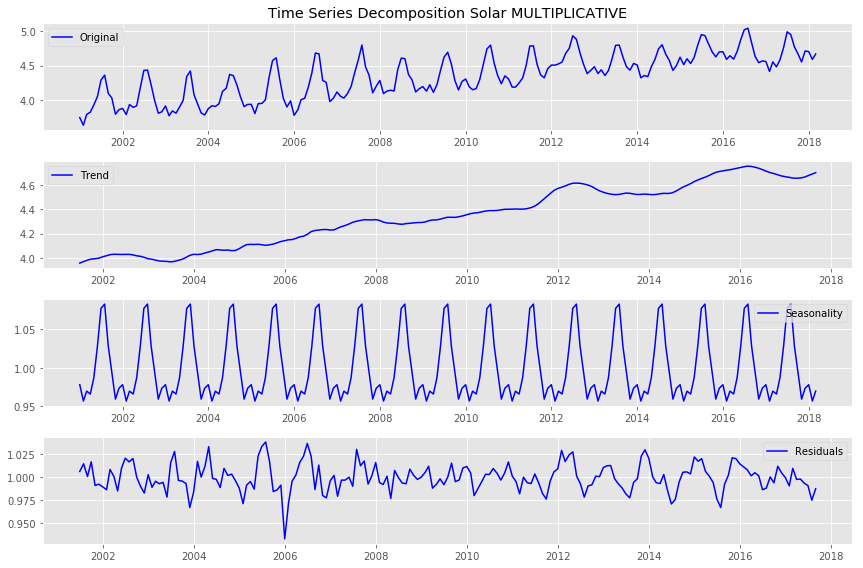

In [268]:
decomposition = seasonal_decompose(np.log(train), model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Solar MULTIPLICATIVE')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

## Studying Autocorrelation

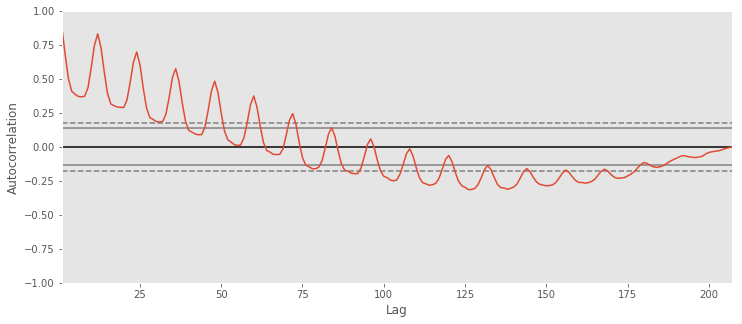

In [269]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(train);

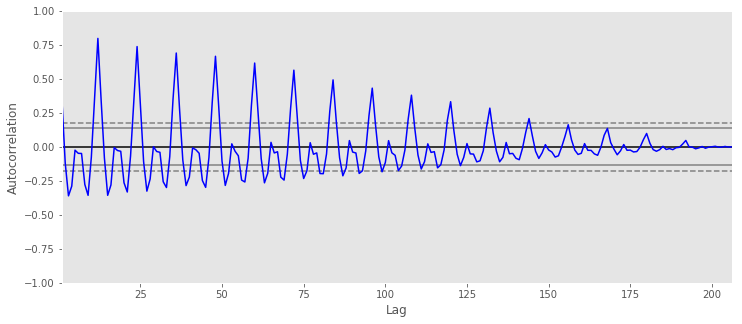

In [270]:
nat_diff = train.diff(periods=1)
nat_diff.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(nat_diff, color='b');

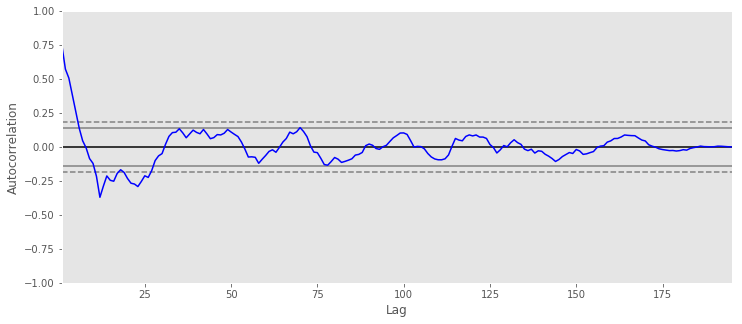

In [271]:
nat_diff12 = train.diff(periods=12)
nat_diff12.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(nat_diff12, color='b');

## PACF

### Natural Gas

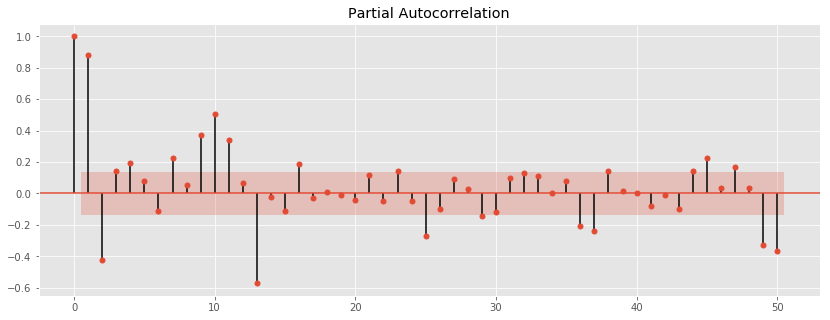

In [272]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(train, lags=50);

## ACF

### Natural Gas

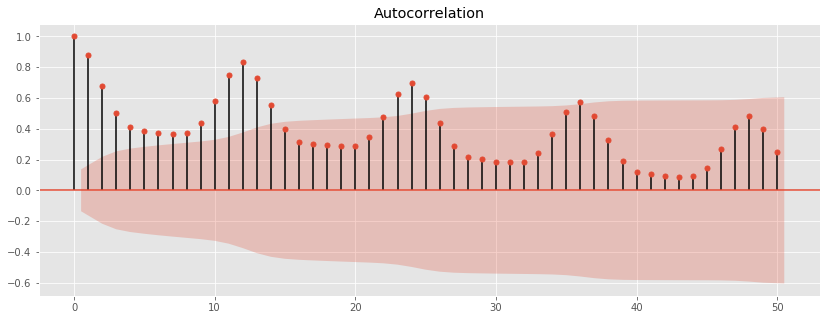

In [273]:
rcParams['figure.figsize'] = 14, 5

plot_acf(train, lags=50);

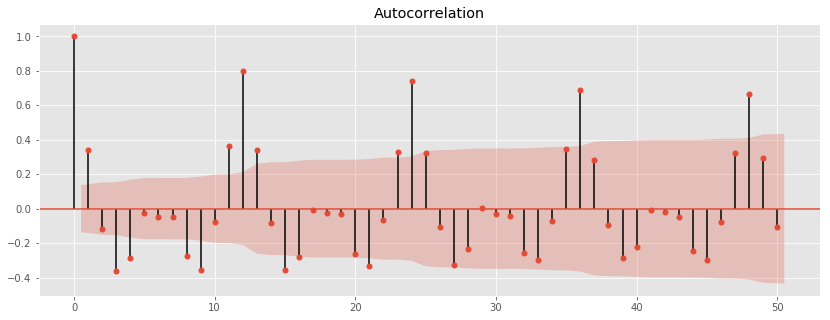

In [274]:
rcParams['figure.figsize'] = 14, 5

plot_acf(nat_diff, lags=50);

### PACF with first difference

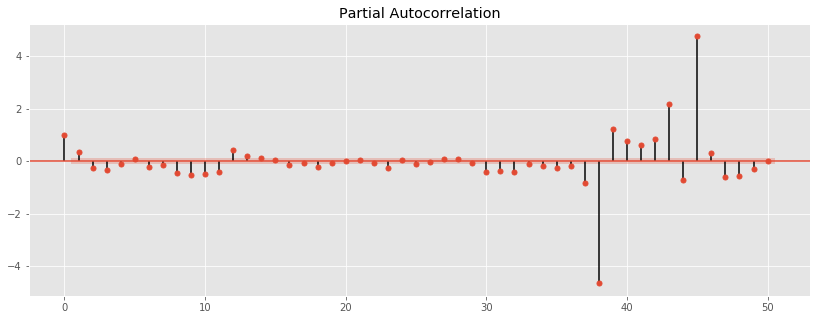

In [275]:
nat_diff = nat.diff(periods=1)
nat_diff.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff, lags=50);

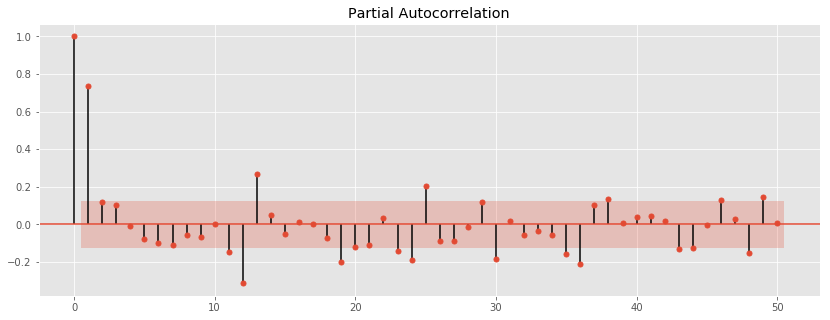

In [276]:
nat_diff = nat.diff(periods=12)
nat_diff.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff, lags=50);

> look into this, why with periods = 12 the pacf makes much mores sense

> also: why does the PACF make more sense with the differenced 1 time series? Try to understand this.

> another idea create a DF with one column per source and then see if there is correlation between them
> the correlation can be seen with df.corr( ) and I can also do it on the series that are differenced

From here on we will dig deeper into natural gas as it is higher in production and is a more stable source of energy since it does not depend on uncontrollable factors like weather, which is the case for solar and wind.
We might go back to solar and wind after finished with Natural if there is time.

# Modeling

## Baseline Model:

> Make Naive Bayes and calculate RMSE as the base to keep

In [277]:
naive = train.shift(1)
naive

date
2001-01-01           NaN
2001-02-01     42.388663
2001-03-01     37.966927
2001-04-01     44.364414
2001-05-01     45.842746
                 ...    
2017-11-01    106.826275
2017-12-01     94.928341
2018-01-01    111.397792
2018-02-01    110.292909
2018-03-01     98.511852
Name: Generation (TWh), Length: 207, dtype: float64

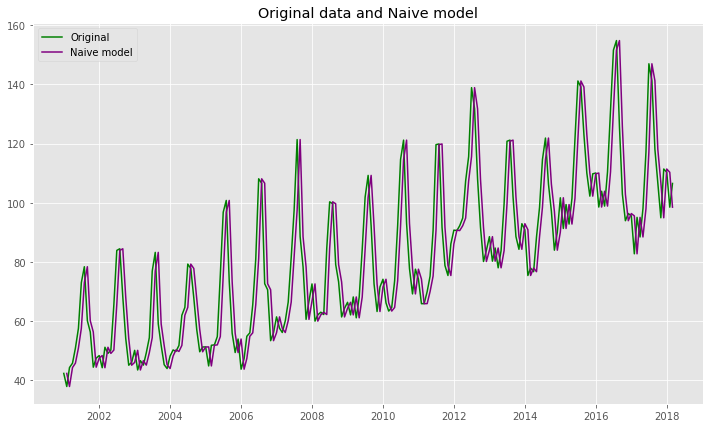

In [278]:
fig = plt.figure(figsize=(12,7))
plt.plot(train, color='green', label='Original')
plt.plot(naive, color='purple', label='Naive model')
#plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Original data and Naive model')
plt.show(block=False)

For a baseline to compare our later models, lets calculate our RMSE
 for the naive model.

In [354]:
RMSE_naiv=round(np.sqrt(mean_squared_error(train[1:], naive.dropna())),2)
print(f'{Fore.BLUE}The RMSE fo the naive baseline model is: {RMSE_naiv}{Style.RESET_ALL}')

The RMSE fo the naive baseline model is: 12.32


In [350]:
naive_val = val.shift(1)

In [353]:
RMSE_naiv_val=round(np.sqrt(mean_squared_error(val[1:], naive_val.dropna())),2)
print(f'{Fore.GREEN}The RMSE fo the naive baseline model on the validation set is: {RMSE_naiv_val}{Style.RESET_ALL}')

The RMSE fo the naive baseline model on the validation set is: 15.45


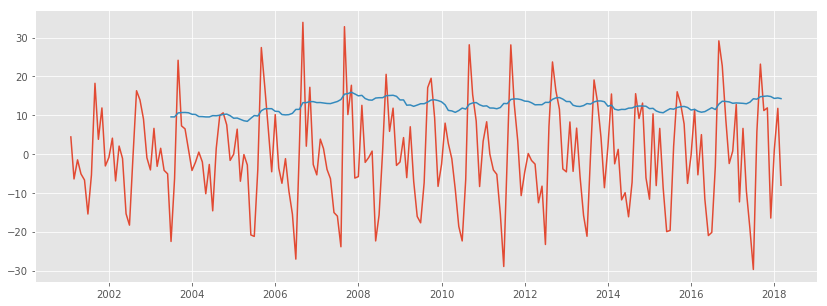

In [74]:
# Plotting rolling standard deviation
# Tocheck if there is a remaining trend
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

If we look at the rolling standard deviation of our errors, we can see that the performance of our model varies at different points in time.

That is a result of the trends in our data.

In the previous notebook, we were able to make our series **stationary** by differencing our data.

Visually, our differenced data looks *more* like white noise:

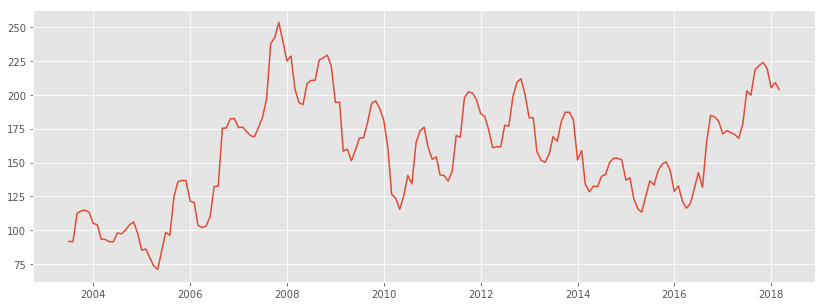

In [75]:
fig, ax = plt.subplots()
# check residuals if they look like random noise
ax.plot(residuals.index, residuals.rolling(30).var());

By removing the trend from our data, we assume that our data's mean and variance are constant throughout. But it is **not** just white noise. If it were, our models could do no better than random predictions around the mean.

Our task now is to find **more patterns** in the series.

We will focus on the data points near to the point in question. We can attempt to find patterns to how much influence previous points in the sequence have.

If that made you think of regression, great! What we will be doing is assigning weights, like our betas, to previous points.

Let's make sure our data after differencing is stationary:

In [76]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.0006537071146531857,
 so we can safely assume that the differenced data is stationary.


## ARMA models

### AR model

In [77]:
mod_ar = ARIMA(train, order=(1,0,0))

In [78]:
# Fit the model to data
res_ar = mod_ar.fit()

In [79]:
# Print out summary information on the fit
print(res_ar.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -808.522
Date:                Mon, 13 Mar 2023   AIC                           1623.044
Time:                        14:14:32   BIC                           1633.042
Sample:                    01-01-2001   HQIC                          1627.087
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.5313      7.535     10.687      0.000      65.762      95.300
ar.L1          0.8870      0.033     26.675      0.000       0.822       0.952
sigma2       143.5185     14.440      9.939      0.0

In [80]:
# Print out the estimate for the constant and for theta
print(res_ar.params)

const      80.531265
ar.L1       0.886972
sigma2    143.518486
dtype: float64


In [81]:
aics=[]
aics.append(['armd', res_ar.aic])
res_ar.aic

1623.0442763976707

### Random Walk

In [82]:
rw = ARIMA(train, order=(0,1,0))

In [83]:
# Fit the model to data
res_rw = rw.fit()

In [84]:
# Print out summary information on the fit
print(res_rw.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -809.685
Date:                Mon, 13 Mar 2023   AIC                           1621.369
Time:                        14:14:33   BIC                           1624.697
Sample:                    01-01-2001   HQIC                          1622.715
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       151.8956     15.111     10.052      0.000     122.279     181.512
Ljung-Box (L1) (Q):                  24.64   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.00   Pr

In [85]:
aics.append(['rwlk', res_rw.aic])
res_rw.aic

1621.369318497057

### AR with First Difference

In [86]:
mod_arfd = ARIMA(train, order=(1,1,0))

In [87]:
# Fit the model to data
res_arfd = mod_arfd.fit()

In [88]:
# Print out summary information on the fit
print(res_arfd.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -796.759
Date:                Mon, 13 Mar 2023   AIC                           1597.518
Time:                        14:14:34   BIC                           1604.174
Sample:                    01-01-2001   HQIC                          1600.210
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3430      0.068      5.039      0.000       0.210       0.476
sigma2       133.8912     12.171     11.000      0.000     110.036     157.747
Ljung-Box (L1) (Q):                   1.82   Jarque-

In [89]:
aics.append(['arfd', res_arfd.aic])
res_arfd.aic

1597.5180605192918

### ARMA with first difference

In [90]:
mod_arma = ARIMA(train, order=(1,1,1))

In [91]:
# Fit the model to data
res_arma = mod_arma.fit()

In [92]:
# Print out summary information on the fit
print(res_arma.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -793.475
Date:                Mon, 13 Mar 2023   AIC                           1592.950
Time:                        14:14:35   BIC                           1602.933
Sample:                    01-01-2001   HQIC                          1596.987
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0746      0.164      0.455      0.649      -0.247       0.396
ma.L1          0.3375      0.147      2.300      0.021       0.050       0.625
sigma2       129.6560     12.546     10.334      0.0

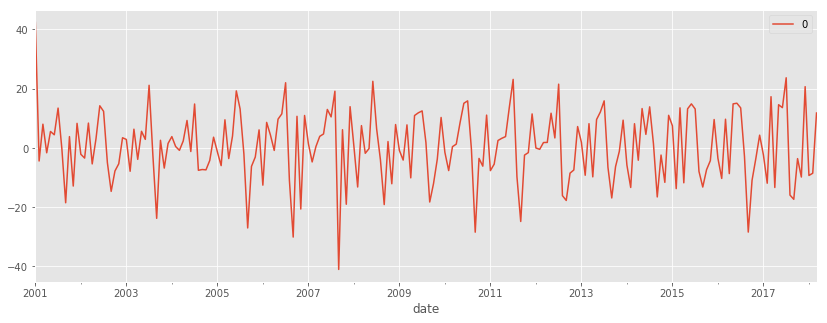

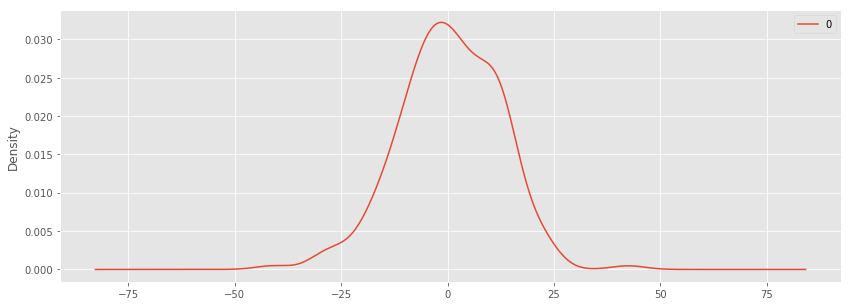

                0
count  207.000000
mean     0.435011
std     11.756272
min    -41.044733
25%     -7.338286
50%      0.465362
75%      9.421939
max     42.388663


In [93]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [94]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.075838
p-value                          0.001062
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


In [95]:
aics.append(['arma', res_arma.aic])
res_arma.aic

1592.9496080854847

In [96]:
aics

[['armd', 1623.0442763976707],
 ['rwlk', 1621.369318497057],
 ['arfd', 1597.5180605192918],
 ['arma', 1592.9496080854847]]

### Trying higher orders

#### 211

In [97]:
mod_arma211 = ARIMA(train, order=(2,1,1))

In [98]:
# Fit the model to data
res_arma211 = mod_arma211.fit()

In [99]:
# Print out summary information on the fit
print(res_arma211.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -765.855
Date:                Mon, 13 Mar 2023   AIC                           1539.711
Time:                        14:14:37   BIC                           1553.022
Sample:                    01-01-2001   HQIC                          1545.094
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1311      0.065     17.443      0.000       1.004       1.258
ar.L2         -0.5445      0.059     -9.232      0.000      -0.660      -0.429
ma.L1         -0.9233      0.037    -24.912      0.0

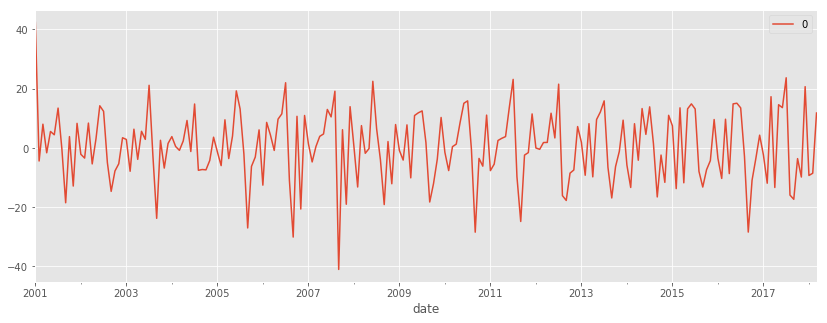

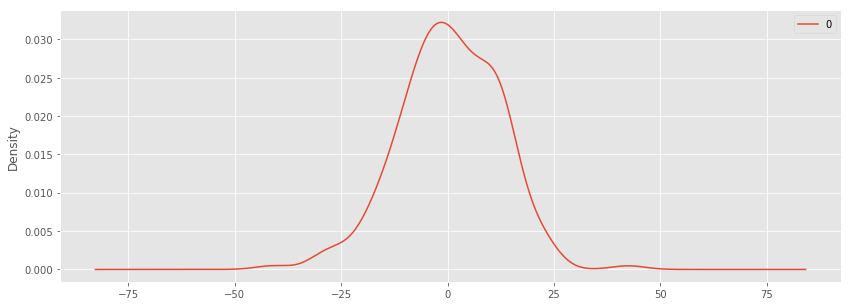

                0
count  207.000000
mean     0.435011
std     11.756272
min    -41.044733
25%     -7.338286
50%      0.465362
75%      9.421939
max     42.388663


In [100]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [101]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.075838
p-value                          0.001062
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


In [102]:
aics.append(['arma211', res_arma211.aic])
res_arma211.aic

1539.7106340464702

#### 212

In [103]:
mod_arma212 = ARIMA(train, order=(2,1,2))

In [104]:
res_arma212 = mod_arma212.fit()

In [105]:
print(res_arma212.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -765.403
Date:                Mon, 13 Mar 2023   AIC                           1540.805
Time:                        14:14:38   BIC                           1557.445
Sample:                    01-01-2001   HQIC                          1547.535
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2238      0.126      9.706      0.000       0.977       1.471
ar.L2         -0.6165      0.105     -5.865      0.000      -0.822      -0.410
ma.L1         -1.0557      0.158     -6.662      0.0

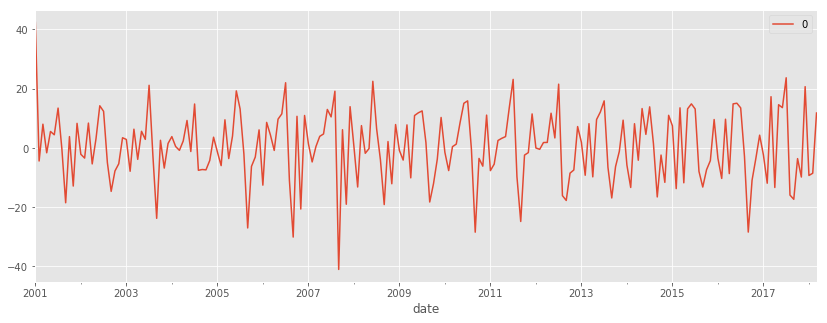

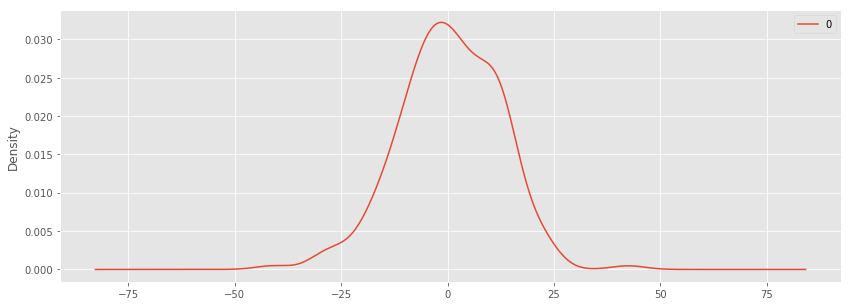

                0
count  207.000000
mean     0.435011
std     11.756272
min    -41.044733
25%     -7.338286
50%      0.465362
75%      9.421939
max     42.388663


In [106]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [107]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.075838
p-value                          0.001062
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


In [108]:
aics.append(['arma212', res_arma212.aic])
res_arma212.aic

1540.8052386695467

#### 214

In [109]:
mod_arma214 = ARIMA(train, order=(2,1,4))

In [110]:
res_arma214 = mod_arma214.fit()

In [111]:
print(res_arma214.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -763.744
Date:                Mon, 13 Mar 2023   AIC                           1541.489
Time:                        14:14:40   BIC                           1564.784
Sample:                    01-01-2001   HQIC                          1550.910
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0615      0.267     -0.230      0.818      -0.585       0.462
ar.L2         -0.0879      0.183     -0.480      0.631      -0.447       0.271
ma.L1          0.2887      0.251      1.151      0.2

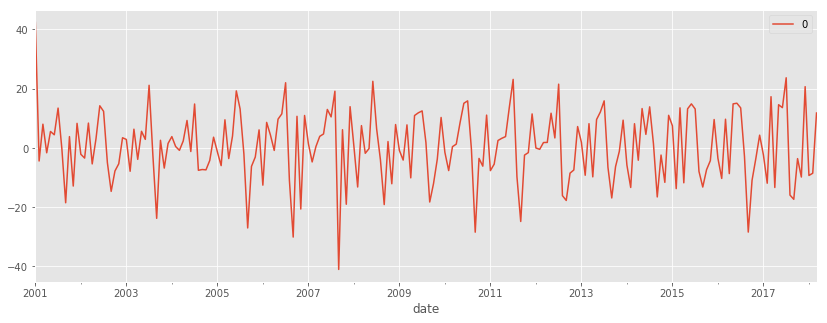

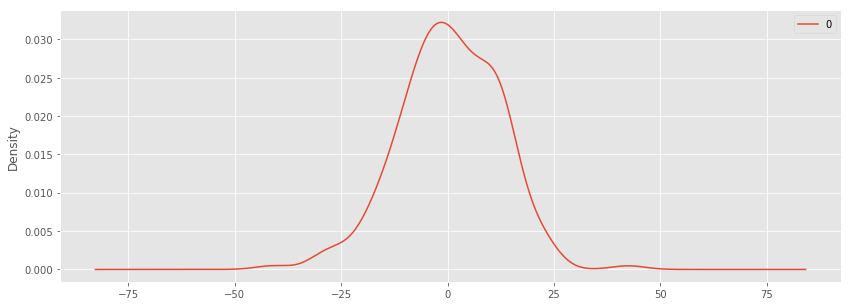

                0
count  207.000000
mean     0.435011
std     11.756272
min    -41.044733
25%     -7.338286
50%      0.465362
75%      9.421939
max     42.388663


In [112]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [113]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.075838
p-value                          0.001062
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


In [114]:
aics.append(['arma214', res_arma214.aic])
res_arma214.aic

1541.4889297105426

#### 015

In [115]:
mod_arma015 = ARIMA(train, order=(0,1,5))

In [116]:
res_arma015 = mod_arma015.fit()

In [117]:
print(res_arma015.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(0, 1, 5)   Log Likelihood                -763.889
Date:                Mon, 13 Mar 2023   AIC                           1539.779
Time:                        14:14:41   BIC                           1559.746
Sample:                    01-01-2001   HQIC                          1547.854
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2244      0.061      3.677      0.000       0.105       0.344
ma.L2         -0.2100      0.066     -3.173      0.002      -0.340      -0.080
ma.L3         -0.4808      0.065     -7.426      0.0

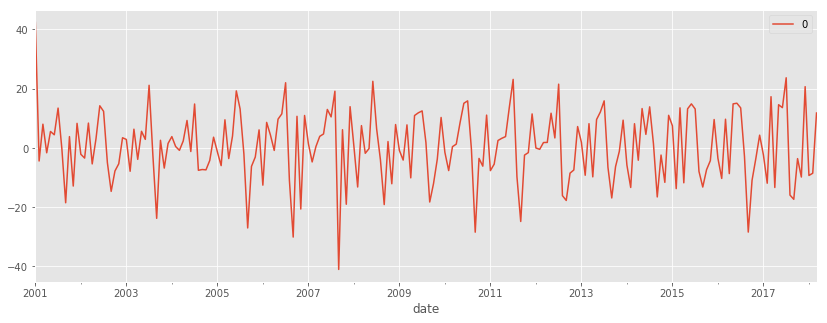

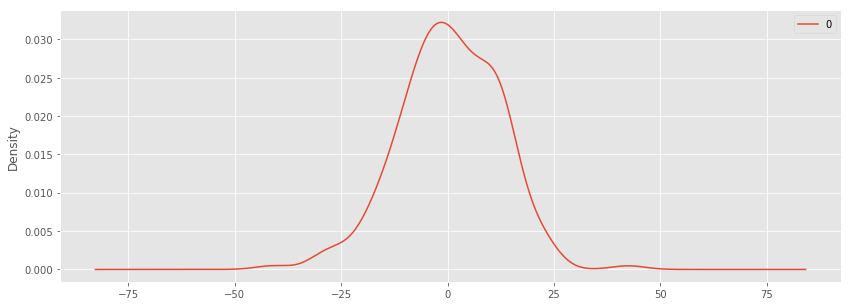

                0
count  207.000000
mean     0.435011
std     11.756272
min    -41.044733
25%     -7.338286
50%      0.465362
75%      9.421939
max     42.388663


In [118]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())



In [119]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.075838
p-value                          0.001062
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


In [120]:
aics.append(['arma015', res_arma015.aic])
aics

[['armd', 1623.0442763976707],
 ['rwlk', 1621.369318497057],
 ['arfd', 1597.5180605192918],
 ['arma', 1592.9496080854847],
 ['arma211', 1539.7106340464702],
 ['arma212', 1540.8052386695467],
 ['arma214', 1541.4889297105426],
 ['arma015', 1539.778813089486]]

## Grid search for ARIMA model

Defining a few functions to do a grid search on the ARIMA model.

In [121]:
"""# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
     # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
"""

'# evaluate an ARIMA model for a given order (p,d,q)\ndef evaluate_arima_model(X, arima_order):\n    # prepare training dataset\n    train_size = int(len(X) * 0.66)\n    train, test = X[0:train_size], X[train_size:]\n    history = [x for x in train]\n    # make predictions\n    predictions = list()\n    for t in range(len(test)):\n        model = ARIMA(history, order=arima_order)\n        model_fit = model.fit()\n        yhat = model_fit.forecast()[0]\n        predictions.append(yhat)\n        history.append(test[t])\n     # calculate out of sample error\n    error = mean_squared_error(test, predictions)\n    return error\n'

In [122]:
"""# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model_aic(X, arima_order):
    # prepare training dataset
#    train_size = int(len(X) * 0.66)
#    train, test = X[0:train_size], X[train_size:]
#    history = [x for x in train]
    # make predictions
#    predictions = list()
#    for t in range(len(test)):
    model = ARIMA(X, order=arima_order)
    model_fit = model.fit()
    aic=model_fit.aic
#        yhat = model_fit.forecast()[0]
#        predictions.append(yhat)
#        history.append(test[t])
     # calculate out of sample error
#    error = mean_squared_error(test, predictions)
#    return error
    return aic
    """

'# evaluate an ARIMA model for a given order (p,d,q)\ndef evaluate_arima_model_aic(X, arima_order):\n    # prepare training dataset\n#    train_size = int(len(X) * 0.66)\n#    train, test = X[0:train_size], X[train_size:]\n#    history = [x for x in train]\n    # make predictions\n#    predictions = list()\n#    for t in range(len(test)):\n    model = ARIMA(X, order=arima_order)\n    model_fit = model.fit()\n    aic=model_fit.aic\n#        yhat = model_fit.forecast()[0]\n#        predictions.append(yhat)\n#        history.append(test[t])\n     # calculate out of sample error\n#    error = mean_squared_error(test, predictions)\n#    return error\n    return aic\n    '

In [123]:
"""# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))"""

'# evaluate combinations of p, d and q values for an ARIMA model\ndef evaluate_models(dataset, p_values, d_values, q_values):\n    dataset = dataset.astype(\'float32\')\n    best_score, best_cfg = float("inf"), None\n    for p in p_values:\n        for d in d_values:\n            for q in q_values:\n                order = (p,d,q)\n                try:\n                    mse = evaluate_arima_model(dataset, order)\n                    if mse < best_score:\n                        best_score, best_cfg = mse, order\n                    print(\'ARIMA%s MSE=%.3f\' % (order,mse))\n                except:\n                    continue\n    print(\'Best ARIMA%s MSE=%.3f\' % (best_cfg, best_score))'

In [124]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_aic(dataset, p_values, d_values, q_values):   
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()
                    aic=model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

## Time for an ARIMA grid search on the train

In [125]:
# evaluate parameters
p_values = [1, 2, 4, 6, 8]
d_values = range(1, 3)
q_values = range(1, 3)
warnings.filterwarnings("ignore")
evaluate_models_aic(train, p_values, d_values, q_values)

ARIMA(1, 1, 1) AIC=1592.950
ARIMA(1, 1, 2) AIC=1562.919
ARIMA(1, 2, 1) AIC=1597.197
ARIMA(1, 2, 2) AIC=1592.754
ARIMA(2, 1, 1) AIC=1539.711
ARIMA(2, 1, 2) AIC=1540.805
ARIMA(2, 2, 1) AIC=1584.169
ARIMA(2, 2, 2) AIC=1531.569
ARIMA(4, 1, 1) AIC=1568.974
ARIMA(4, 1, 2) AIC=1544.112
ARIMA(4, 2, 1) AIC=1571.912
ARIMA(4, 2, 2) AIC=1575.532
ARIMA(6, 1, 1) AIC=1516.308
ARIMA(6, 1, 2) AIC=1454.412
ARIMA(6, 2, 1) AIC=1561.556
ARIMA(6, 2, 2) AIC=1511.849
ARIMA(8, 1, 1) AIC=1472.259
ARIMA(8, 1, 2) AIC=1401.174
ARIMA(8, 2, 1) AIC=1524.379
ARIMA(8, 2, 2) AIC=1469.653
Best ARIMA(8, 1, 2) AIC=1401.174


### Best model from first ARIMA search

In [288]:
model_train1st = ARIMA(train, order=(8,1,2)).fit()
#res_arma = model_train.fit()
print(model_train1st.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -689.587
Date:                Mon, 13 Mar 2023   AIC                           1401.174
Time:                        18:18:14   BIC                           1437.781
Sample:                    01-01-2001   HQIC                          1415.979
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9880      0.058     17.130      0.000       0.875       1.101
ar.L2         -0.8937      0.086    -10.412      0.000      -1.062      -0.725
ar.L3          0.0402      0.101      0.396      0.6

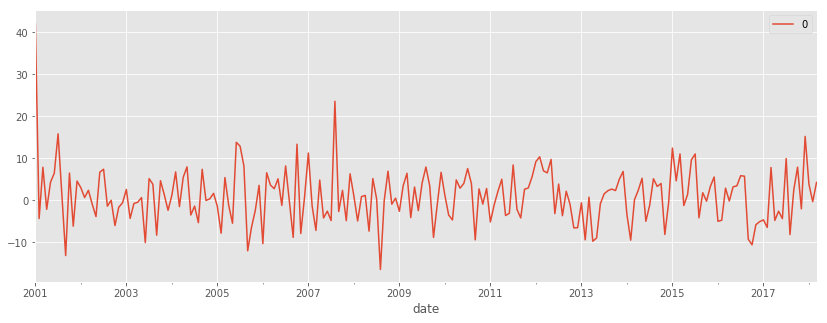

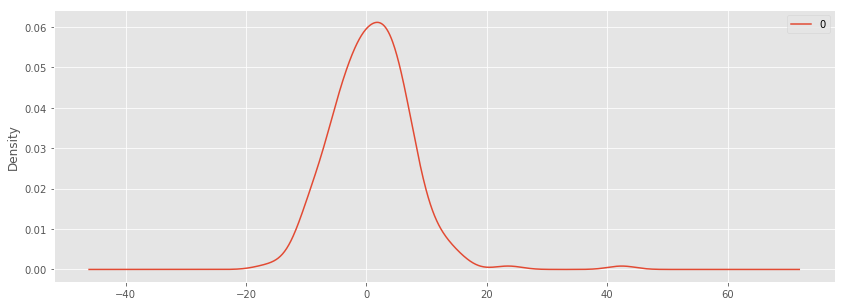

                0
count  207.000000
mean     0.933168
std      6.691557
min    -16.568282
25%     -3.585551
50%      0.804745
75%      4.873049
max     42.388663


In [289]:
# line plot of residuals
residuals = pd.DataFrame(model_train.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


In [290]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -1.640131e+01
p-value                        2.636564e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


In [291]:
y_hat_train = model_train1st.predict(typ='levels')
RMSE_train=round(np.sqrt(mean_squared_error(train, y_hat_train)),2)
print(f'{Fore.GREEN}The RMSE for the best ARMA model after first grid, on the train is: {RMSE_train}{Style.RESET_ALL}')

The RMSE for the best ARMA model after first grid, on the train is: 7.45


This is a good result considering that the RMSE for the naive model was around 12.
But let us see if we can improve this even further buy doing one more ARIMA search.

### Let's try another grid search for ARIMA

In [130]:
# evaluate parameters
p_values = [8, 10, 12, 20]
d_values = [1,2]
q_values = [1,2]
warnings.filterwarnings("ignore")
evaluate_models_aic(train.values, p_values, d_values, q_values)

ARIMA(8, 1, 1) AIC=1472.259
ARIMA(8, 1, 2) AIC=1401.174
ARIMA(8, 2, 1) AIC=1524.379
ARIMA(8, 2, 2) AIC=1469.653
ARIMA(10, 1, 1) AIC=1430.631
ARIMA(10, 1, 2) AIC=1382.235
ARIMA(10, 2, 1) AIC=1428.363
ARIMA(10, 2, 2) AIC=1405.720
ARIMA(12, 1, 1) AIC=1355.815
ARIMA(12, 1, 2) AIC=1357.197
ARIMA(12, 2, 1) AIC=1363.006
ARIMA(12, 2, 2) AIC=1365.921
ARIMA(20, 1, 1) AIC=1359.881
ARIMA(20, 1, 2) AIC=1361.479
ARIMA(20, 2, 1) AIC=1364.163
ARIMA(20, 2, 2) AIC=1361.240
Best ARIMA(12, 1, 1) AIC=1355.815


Taking the best model from this search

In [292]:
model_train2nd = ARIMA(train, order=(12, 1, 1)).fit()
#res_arma = mod_arma
print(model_train2nd.summary())

                               SARIMAX Results                                
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                ARIMA(12, 1, 1)   Log Likelihood                -663.908
Date:                Mon, 13 Mar 2023   AIC                           1355.815
Time:                        18:19:07   BIC                           1402.406
Sample:                    01-01-2001   HQIC                          1374.658
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0511      0.111      0.460      0.645      -0.167       0.269
ar.L2         -0.1727      0.067     -2.591      0.010      -0.303      -0.042
ar.L3         -0.1214      0.075     -1.618      0.1

In [293]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -1.640131e+01
p-value                        2.636564e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.060000e+02
Critical Value (1%)           -3.462499e+00
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
dtype: float64


In [294]:
y_hat_train = model_train2nd.predict(typ='levels')
RMSE_train=round(np.sqrt(mean_squared_error(train, y_hat_train)),2)
print(f'{Fore.BLUE}The RMSE for the ARMA best model after second grid search on the train is: {RMSE_train}{Style.RESET_ALL}')

The RMSE for the ARMA best model after second grid search on the train is: 6.74


This is even better, but let us keep in mind that this number is in TWh, we would like for it to go down even further.
There is something else happening in our time series that we haven't taken into account yet, and definitely plays a major role: seasonality.
So let us try now using a SARIMAX model which includes also 4 more terms, to account for seasonality.

# Including Seasonality: SARIMAX

> Add a paragraph that explains why we need to do this and why it's powerful.

## First Grid Search SARIMAX

In [134]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4,  6, 8]
d = [1, 2, 4]
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [135]:
"""
CODE that was used to conduct the SARIMAX grid search:

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

"\nCODE that was used to conduct the SARIMAX grid search:\n\nans = []\nfor comb in pdq:\n    for combs in pdqs:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(train,\n                                            order=comb,\n                                            seasonal_order=combs,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            output = mod.fit()\n            ans.append([comb, combs, output.aic])\n            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))\n        except:\n            continue"

In [136]:
""" CODE used to extract the model with lowest AIC

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

" CODE used to extract the model with lowest AIC\n\n# Find the parameters with minimal AIC value\nans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])\nans_df.loc[ans_df['aic'].idxmin()]"

The output of our code suggests that ARIMA (1, 1, 1) x (1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

It is very time consuming to run all of the options so we pickled the GridSearchCV models after we ran them and fit them.
The pickled files were also too large for the Github Repository so we had to remove them.
We show below all the code that was used for demonastrative purposes, but we comment it out and keep only the results of the search.


In [137]:
# CODE used to pickle df of results
# ans_df.to_pickle("./SARgrid1.pkl")

In [138]:
res_grid_df = pd.read_pickle("./SARgrid1.pkl")  
res_grid_df 

pdq           pdqs          aic
0    (1, 1, 1)  (1, 1, 1, 12)  1113.796469
1    (1, 1, 1)  (1, 1, 2, 12)  1045.444905
2    (1, 1, 1)  (1, 2, 1, 12)  1119.203731
3    (1, 1, 1)  (1, 2, 2, 12)  1008.666022
4    (1, 1, 1)  (1, 4, 1, 12)  1186.233740
..         ...            ...          ...
895  (8, 4, 2)  (8, 1, 2, 12)   598.278003
896  (8, 4, 2)  (8, 2, 1, 12)   581.777049
897  (8, 4, 2)  (8, 2, 2, 12)   566.100169
898  (8, 4, 2)  (8, 4, 1, 12)   643.207771
899  (8, 4, 2)  (8, 4, 2, 12)   598.977431

[900 rows x 3 columns]

In [139]:
res_grid_df.sort_values(by='aic').head(10)

pdq           pdqs         aic
838  (8, 2, 2)  (8, 4, 1, 12)  390.300560
568  (6, 1, 1)  (8, 4, 1, 12)  401.144101
749  (8, 1, 1)  (8, 4, 2, 12)  404.020123
598  (6, 1, 2)  (8, 4, 1, 12)  406.228081
779  (8, 1, 2)  (8, 4, 2, 12)  407.293806
388  (4, 1, 1)  (8, 4, 1, 12)  412.478274
569  (6, 1, 1)  (8, 4, 2, 12)  412.843780
599  (6, 1, 2)  (8, 4, 2, 12)  415.171388
839  (8, 2, 2)  (8, 4, 2, 12)  416.268315
628  (6, 2, 1)  (8, 4, 1, 12)  424.192994

### 3 Best SARIMAX models according to first grid search

In [140]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL1 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(8, 2, 2), 
                                        seasonal_order=(8, 4, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output1 = ARIMA_MODEL1.fit()

print(output1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5381      0.991     -0.543      0.587      -2.480       1.404
ar.L2         -0.0563      0.567     -0.099      0.921      -1.167       1.054
ar.L3         -0.2800      0.383     -0.732      0.464      -1.030       0.470
ar.L4         -0.1306      0.456     -0.287      0.774      -1.024       0.763
ar.L5          0.3590      0.306      1.174      0.241      -0.241       0.959
ar.L6         -0.0661      0.368     -0.180      0.857      -0.787       0.655
ar.L7         -0.4037      0.228     -1.772      0.076      -0.850       0.043
ar.L8          0.0868      0.466      0.186      0.852      -0.827       1.000
ma.L1         -0.8643      0.889     -0.972      0.331      -2.607       0.879
ma.L2         -0.4374      1.056     -0.414      0.679      -2.508       1.633
ar.S.L12      -2.2225      0.228     -9.764      0.0

The model returns a lot of information, but we'll focus only on the table of coefficients. The coef column above shows the importance of each feature and how each one impacts the time series patterns. The  𝑃>|𝑧|
  provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

In [141]:
y_hat_train1 = output1.predict(typ='levels')
RMSE_train1=np.sqrt(mean_squared_error(train, y_hat_train1))
RMSE_train1
#8.93

20.61406919389055

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated.

Call the .plot_diagnostics( ) method on ARIMA output below:

In [142]:
# Call plot_diagnostics() on the results calculated above 
#output1.plot_diagnostics(figsize=(15, 18))
#plt.show()

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [143]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL2 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(6, 1, 1), 
                                        seasonal_order=(8, 4, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
#(6, 1, 1)	(8, 4, 1, 12)
#(1,2,3)   (2,1,4,12)
# Fit the model and print results
output2 = ARIMA_MODEL2.fit()

print(output2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1644      0.808      0.203      0.839      -1.419       1.748
ar.L2          0.1707      0.235      0.726      0.468      -0.290       0.632
ar.L3         -0.2176      0.255     -0.853      0.393      -0.717       0.282
ar.L4          0.2240      0.255      0.878      0.380      -0.276       0.724
ar.L5          0.1289      0.218      0.592      0.554      -0.298       0.556
ar.L6         -0.0706      0.240     -0.294      0.769      -0.542       0.400
ma.L1         -0.2629      0.764     -0.344      0.731      -1.760       1.234
ar.S.L12      -2.4560      0.184    -13.361      0.000      -2.816      -2.096
ar.S.L24      -3.4556      0.432     -8.008      0.000      -4.301      -2.610
ar.S.L36      -4.1703      0.633     -6.591      0.000      -5.410      -2.930
ar.S.L48      -4.1892      0.706     -5.932      0.0

In [144]:
y_hat_train2 = output2.predict(typ='levels')
RMSE_train2=np.sqrt(mean_squared_error(train, y_hat_train2))
RMSE_train2
#8.050144231799374

15.714580522391572

In [146]:
# Call plot_diagnostics() on the results calculated above 
#output2.plot_diagnostics(figsize=(15, 18))
#plt.show()

In [147]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL3 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(8, 1, 1), 
                                        seasonal_order=(8, 4, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
#(1,2,4)   (1,2,4,12)
#(8, 1, 1)	(8, 4, 2, 12)	
# Fit the model and print results
output3 = ARIMA_MODEL3.fit()

print(output3.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9464      0.224     -4.227      0.000      -1.385      -0.508
ar.L2         -0.0129      0.315     -0.041      0.967      -0.630       0.605
ar.L3         -0.0865      0.329     -0.263      0.792      -0.731       0.558
ar.L4         -0.0958      0.283     -0.338      0.735      -0.651       0.459
ar.L5          0.1738      0.322      0.540      0.589      -0.457       0.805
ar.L6         -0.0477      0.266     -0.179      0.858      -0.570       0.475
ar.L7         -0.3476      0.272     -1.279      0.201      -0.880       0.185
ar.L8         -0.2018      0.226     -0.894      0.371      -0.644       0.241
ma.L1          0.9560      0.251      3.809      0.000       0.464       1.448
ar.S.L12      -2.9415      0.243    -12.114      0.000      -3.417      -2.466
ar.S.L24      -4.5835      0.692     -6.625      0.0

In [148]:
y_hat_train3 = output3.predict(typ='levels')
RMSE_train3 = np.sqrt(mean_squared_error(train, y_hat_train3))
RMSE_train3
#1.8683802917343876e+62

18.15044062830905

In [ ]:
# Call plot_diagnostics() on the results calculated above 
#output3.plot_diagnostics(figsize=(15, 18))
#plt.show()

For now it seems that the RMSE has worsened compared to the models before SARIMAX, but let us see because a better AIC usually indicates a better model than RMSE because it decreases the risk of overfitting, penalizing the models that are overfitting the train and will probably do poorly on the test.
We have not validated our model yet, will do so now and will compare the RMSE for the top 2 models (top from ARIMA search and top from SARIMAX search) to see which one does better in terms of RMSE on the validation set.

THESE MODELS SUCK. HIGHER RMSE THAN NAIVE.
LET ME TRY A FEW OTHER ONES HIGHER ORDER.

In [176]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                        order=(8, 1, 2), 
                                        seasonal_order=(8, 1, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output1 = ARIMA_MODEL.fit()

print(output1.summary().tables[1])

y_hat_train1 = output1.predict(typ='levels')
RMSE_train1=np.sqrt(mean_squared_error(train, y_hat_train1))
RMSE_train1

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1554      0.376      0.413      0.680      -0.583       0.893
ar.L2         -0.4098      0.237     -1.727      0.084      -0.875       0.055
ar.L3         -0.0321      0.146     -0.219      0.826      -0.319       0.254
ar.L4          0.1122      0.132      0.847      0.397      -0.147       0.372
ar.L5         -0.0058      0.132     -0.044      0.965      -0.265       0.253
ar.L6          0.1425      0.132      1.082      0.279      -0.115       0.400
ar.L7         -0.3770      0.128     -2.938      0.003      -0.629      -0.126
ar.L8          0.0878      0.197      0.446      0.656      -0.298       0.474
ma.L1         -0.3083      0.369     -0.836      0.403      -1.031       0.415
ma.L2          0.5450      0.252      2.162      0.031       0.051       1.039
ar.S.L12      -0.1574      0.370     -0.426      0.6

7.770396227653417

In [177]:
output1.aic

557.9240064033681

In [165]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                        order=(8, 1, 1), 
                                        seasonal_order=(12, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

y_hat_train1 = output.predict(typ='levels')
RMSE_train1=np.sqrt(mean_squared_error(train, y_hat_train1))
RMSE_train1

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2233      0.327     -0.682      0.495      -0.865       0.418
ar.L2          0.2816      0.248      1.135      0.256      -0.205       0.768
ar.L3          0.4595      0.230      1.999      0.046       0.009       0.910
ar.L4          0.6694      0.350      1.915      0.056      -0.016       1.355
ar.L5          0.1295      0.231      0.560      0.575      -0.323       0.582
ar.L6          0.1655      0.147      1.122      0.262      -0.124       0.454
ar.L7         -0.2953      0.179     -1.654      0.098      -0.645       0.055
ar.L8         -0.5444      0.255     -2.137      0.033      -1.044      -0.045
ma.L1         -0.8957      0.149     -6.029      0.000      -1.187      -0.605
ar.S.L12      -0.9553      0.165     -5.773      0.000      -1.280      -0.631
ar.S.L24      -0.7318      0.246     -2.974      0.0

8.794931084572307

In [166]:
output.aic

239.1361330704412

## Second Grid Search SARIMAX:

In [132]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [8, 12]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [133]:
"""CODE used for the second grid search

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

ARIMA (8, 1, 1) x (8, 1, 1, 12): AIC Calculated=556.5266105137711
ARIMA (8, 1, 1) x (8, 1, 2, 12): AIC Calculated=558.5234507417883
ARIMA (8, 1, 1) x (8, 2, 1, 12): AIC Calculated=508.02085214639226
ARIMA (8, 1, 1) x (8, 2, 2, 12): AIC Calculated=508.03688747399383
ARIMA (8, 1, 1) x (12, 1, 1, 12): AIC Calculated=239.1361330704412
ARIMA (8, 1, 1) x (12, 1, 2, 12): AIC Calculated=241.12902746804596
ARIMA (8, 1, 1) x (12, 2, 1, 12): AIC Calculated=181.37234105838428
ARIMA (8, 1, 1) x (12, 2, 2, 12): AIC Calculated=180.44127549914523
ARIMA (8, 1, 2) x (8, 1, 1, 12): AIC Calculated=556.0718757550113
ARIMA (8, 1, 2) x (8, 1, 2, 12): AIC Calculated=557.9240064033681
ARIMA (8, 1, 2) x (8, 2, 1, 12): AIC Calculated=507.40306815642896
ARIMA (8, 1, 2) x (8, 2, 2, 12): AIC Calculated=512.1729354502153
ARIMA (8, 1, 2) x (12, 1, 1, 12): AIC Calculated=245.29396389308735
ARIMA (8, 1, 2) x (12, 1, 2, 12): AIC Calculated=240.79103505462658
ARIMA (8, 1, 2) x (12, 2, 1, 12): AIC Calculated=173.506577006

In [135]:
"""Results of the second grid search

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

pdq          (8, 1, 2)
pdqs    (12, 2, 1, 12)
aic            173.507
Name: 14, dtype: object

In [136]:
#Pickling the results of the second grid search
#ans_df.to_pickle("./SARgs.pkl")

In [286]:
results_df = pd.read_pickle("./SARgs.pkl")  

In [138]:
results_df.sort_values(by='aic').head(10)

pdq            pdqs         aic
14  (8, 1, 2)  (12, 2, 1, 12)  173.506577
7   (8, 1, 1)  (12, 2, 2, 12)  180.441275
6   (8, 1, 1)  (12, 2, 1, 12)  181.372341
30  (8, 2, 2)  (12, 2, 1, 12)  184.947537
23  (8, 2, 1)  (12, 2, 2, 12)  185.479998
22  (8, 2, 1)  (12, 2, 1, 12)  185.748173
15  (8, 1, 2)  (12, 2, 2, 12)  188.303187
31  (8, 2, 2)  (12, 2, 2, 12)  199.936131
28  (8, 2, 2)  (12, 1, 1, 12)  225.506853
29  (8, 2, 2)  (12, 1, 2, 12)  234.166871

As we can see the AIC values of the top 3 models are all lower than the AICs of the previous top 3, form the first grid search.

## 3 Best SARIMAX model 2nd grid search

In [303]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL4 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(8, 1, 2), 
                                        seasonal_order=(12, 2, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output4 = ARIMA_MODEL4.fit()

print(output4.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5889      1.145     -0.514      0.607      -2.833       1.656
ar.L2          0.3462      0.670      0.517      0.605      -0.966       1.659
ar.L3          0.4048      0.969      0.418      0.676      -1.495       2.305
ar.L4         -0.3232      1.628     -0.199      0.843      -3.513       2.867
ar.L5          0.1956      1.038      0.188      0.851      -1.839       2.230
ar.L6         -0.6552      1.354     -0.484      0.628      -3.309       1.998
ar.L7         -1.0014      1.332     -0.752      0.452      -3.612       1.610
ar.L8          0.3725      1.922      0.194      0.846      -3.395       4.140
ma.L1         -0.6195      5.046     -0.123      0.902     -10.509       9.270
ma.L2          0.9418      4.128      0.228      0.820      -7.148       9.032
ar.S.L12      -1.7841      0.653     -2.734      0.0

In [140]:
y_hat_train4 = output4.predict(typ='levels')
RMSE_train4=np.sqrt(mean_squared_error(train, y_hat_train4))
RMSE_train4

13.437051932831402

In [141]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL5 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(8, 1, 1), 
                                        seasonal_order=(12, 2, 2, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output5 = ARIMA_MODEL5.fit()

print(output5.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2850      0.780     -0.365      0.715      -1.814       1.244
ar.L2          0.7313      0.402      1.820      0.069      -0.056       1.519
ar.L3          0.4634      0.679      0.682      0.495      -0.868       1.795
ar.L4         -0.2900      0.734     -0.395      0.693      -1.729       1.149
ar.L5          0.0973      0.469      0.208      0.835      -0.821       1.016
ar.L6         -0.5744      1.190     -0.483      0.629      -2.907       1.758
ar.L7         -0.4996      0.416     -1.201      0.230      -1.315       0.315
ar.L8          0.7476      0.434      1.721      0.085      -0.104       1.599
ma.L1         -0.3669      1.149     -0.319      0.750      -2.619       1.885
ar.S.L12      -1.9303      0.723     -2.671      0.008      -3.347      -0.514
ar.S.L24      -2.2023      1.573     -1.400      0.1

In [142]:
y_hat_train5 = output5.predict(typ='levels')
RMSE_train5=np.sqrt(mean_squared_error(train, y_hat_train5))
RMSE_train5

12.222994260620471

In [143]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL6 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(8, 1, 1), 
                                        seasonal_order=(12, 2, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output6 = ARIMA_MODEL6.fit()

print(output6.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2309      1.202     -0.192      0.848      -2.586       2.124
ar.L2          0.5428      1.005      0.540      0.589      -1.426       2.512
ar.L3          0.6559      0.897      0.731      0.465      -1.102       2.414
ar.L4         -0.2726      0.872     -0.313      0.755      -1.981       1.436
ar.L5         -0.0495      0.982     -0.050      0.960      -1.975       1.876
ar.L6         -0.2117      0.791     -0.268      0.789      -1.762       1.339
ar.L7         -0.4412      0.503     -0.877      0.380      -1.427       0.545
ar.L8          0.4836      0.766      0.631      0.528      -1.018       1.986
ma.L1         -0.4923      1.154     -0.427      0.670      -2.753       1.769
ar.S.L12      -1.9648      0.763     -2.575      0.010      -3.460      -0.469
ar.S.L24      -2.3765      1.704     -1.395      0.1

In [144]:
y_hat_train6 = output6.predict(typ='levels')
RMSE_train6=np.sqrt(mean_squared_error(train, y_hat_train6))
RMSE_train6

10.531495857610942

#### In terms of the RMSE:
The first 5 models from the 2 grid searchs are worse than the naive model.
<br>The sixth one is better than the naive model, but still worse than our top model from the ARIMA search.
#### In terms of AIC:
The ARMA models (before the SARIMAX searches) all had AICs above 1000.
<br>The models from the SARIMAX grid search have all AICs below 400.
#### Which metric
There is a substantial difference between these two metrics, and we will use them both to evaluate our best two models and see which one performs best on the validation set.
<br>Because of this we will take the model with the overall best RMSE, and the one with the lowest AIC and compare them.
<br>These are the model after the second ARIMA search, with parameters (12, 1, 1), with RMSE 6.74, and the model after the second SARIMAX search, with parameters (8, 1, 2)	(12, 2, 1, 12) and AIC	173.5.

## Validating the models

Do both one-step-ahead and dynamic forecasting, maybe with top 3 performing models.
Calculating RMSE on the train and the validation set, to choose the best model.

### One step Ahead Forecasting

#### ARMA Model

In [328]:
arma = ARIMA(nat, order=(12, 1, 1)).fit()
#res_arma = mod_arma
#print(arma.summary())

In [332]:
pred1 = arma.get_prediction(start=pd.to_datetime('2018-03-01'),end=pd.to_datetime('2019-04-01'), dynamic=False)
pred_conf = pred1.conf_int()

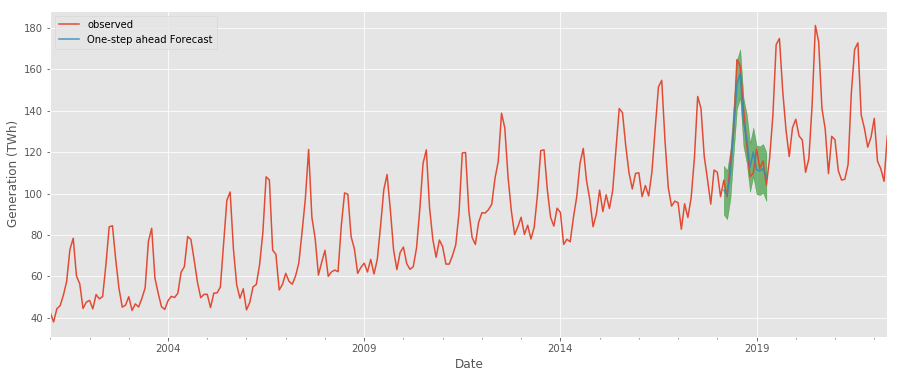

In [333]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nat.plot(label='observed')

# Plot predicted values
pred1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')
plt.legend()

plt.show()

In [340]:
# Get the real and predicted values
nat_forecasted = pred1.predicted_mean
nat_truth = val

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 38.61


#### SARIMA Model

In [335]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA = sm.tsa.statespace.SARIMAX(nat, 
                                        order=(8, 1, 2), 
                                        seasonal_order=(12, 2, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = SARIMA.fit()

In [336]:
pred2 = output.get_prediction(start=pd.to_datetime('2018-04-01'), end=pd.to_datetime('2019-04-01'), dynamic=False)
pred_conf = pred2.conf_int()

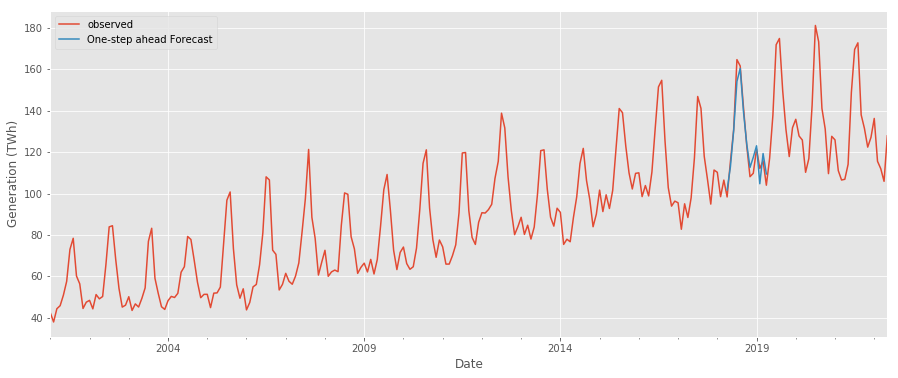

In [337]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nat.plot(label='observed')

# Plot predicted values
pred2.predicted_mean.plot(label='One-step ahead Forecast')

# Plot the range for confidence intervals
#ax.fill_between(pred_conf.index,
#                pred_conf.iloc[:, 0],
#                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')
plt.legend()

plt.show()

In [339]:
# Get the real and predicted values
nat_forecasted = pred2.predicted_mean
nat_truth = val

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 24.2


### Dynamic Forecasting

#### ARMA model

In [341]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic1 = arma.get_prediction(pd.to_datetime('2018-03-01'), end=pd.to_datetime('2019-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic1.conf_int()

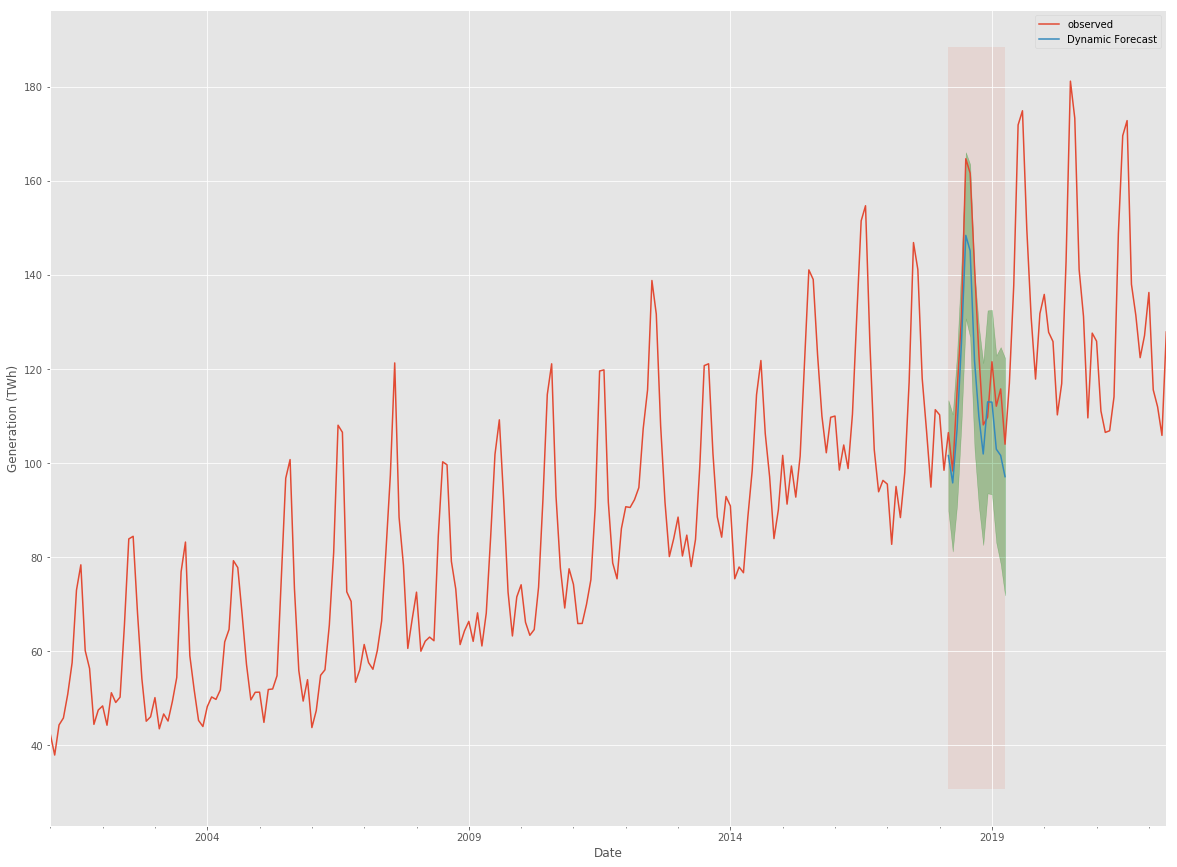

In [342]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic1.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [343]:
# Get the real and predicted values
nat_forecasted = pred_dynamic1.predicted_mean
nat_truth = val

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 120.36


#### SARIMA model

In [344]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic2 = output.get_prediction(pd.to_datetime('2018-03-01'), end=pd.to_datetime('2019-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic2.conf_int()

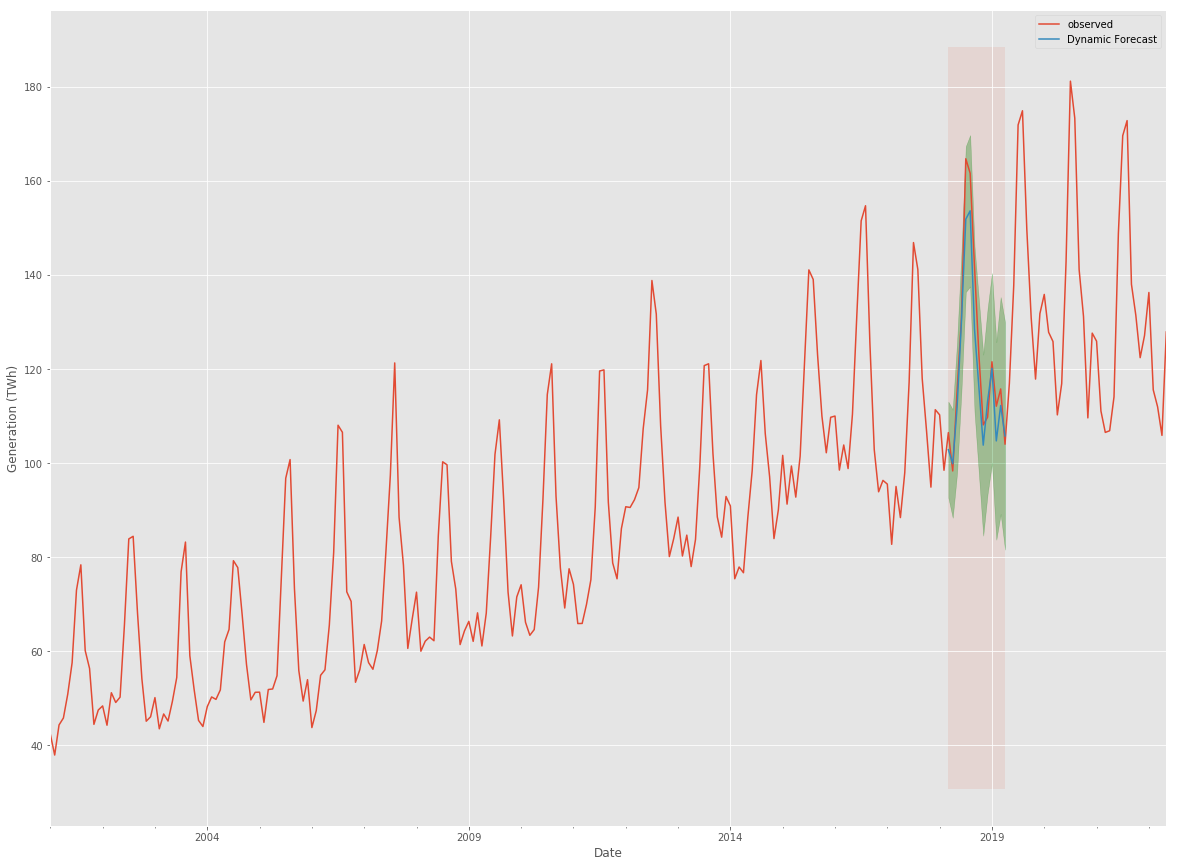

In [345]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic2.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [347]:
# Get the real and predicted values
nat_forecasted = pred_dynamic2.predicted_mean
nat_truth = train

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 13.22


In [356]:
print(f'Let us remember that the RMSE of the naive model on the validation set was {RMSE_naiv_val}')

Let us remember that the RMSE of the naive model on the validation set was 15.45


The model with the overall lowest RMSE is the second one, coming from the SARIMAX grid search, with dynamic forecasting, and it managed to get a lower RMSE on the validation set than the naive model.
<br>We are going to proceed with this model for testing on the test set, and later for forecasting.

## Testing model on the test set

In [358]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic3 = output.get_prediction(pd.to_datetime('2019-04-01'), end=pd.to_datetime('2022-05-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic3.conf_int()

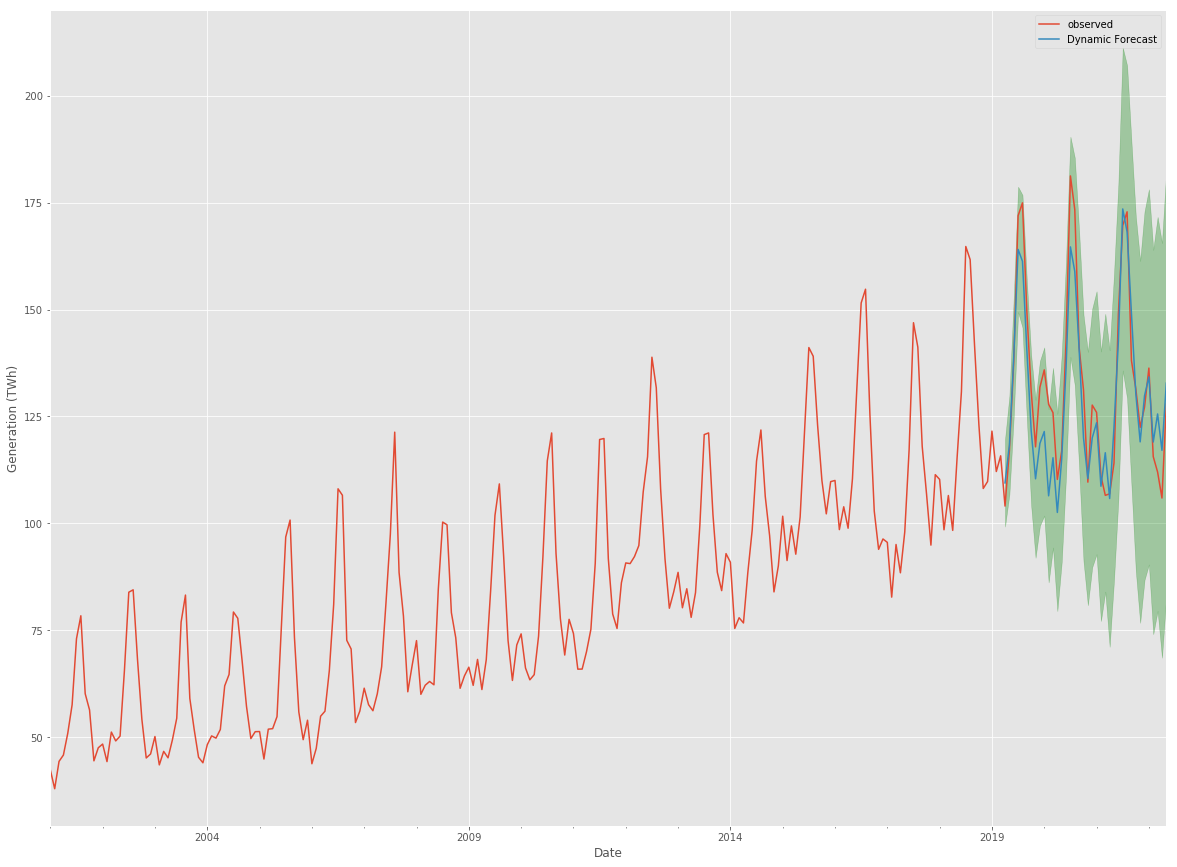

In [360]:
# Plot the dynamic forecast with confidence intervals.

ax = nat.plot(label='observed', figsize=(20, 15))
pred_dynamic3.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

#ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-03-01'), nat_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Generation (TWh)')

plt.legend()
plt.show()

In [361]:
# Get the real and predicted values
nat_forecasted = pred_dynamic3.predicted_mean
nat_truth = test

# Compute the mean square error
mse = ((nat_forecasted - nat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 78.37


## Forecasting

We need to set the number of steps. Every step is a month, if we want to predict 3 years in the future that is 36 steps.

In [362]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

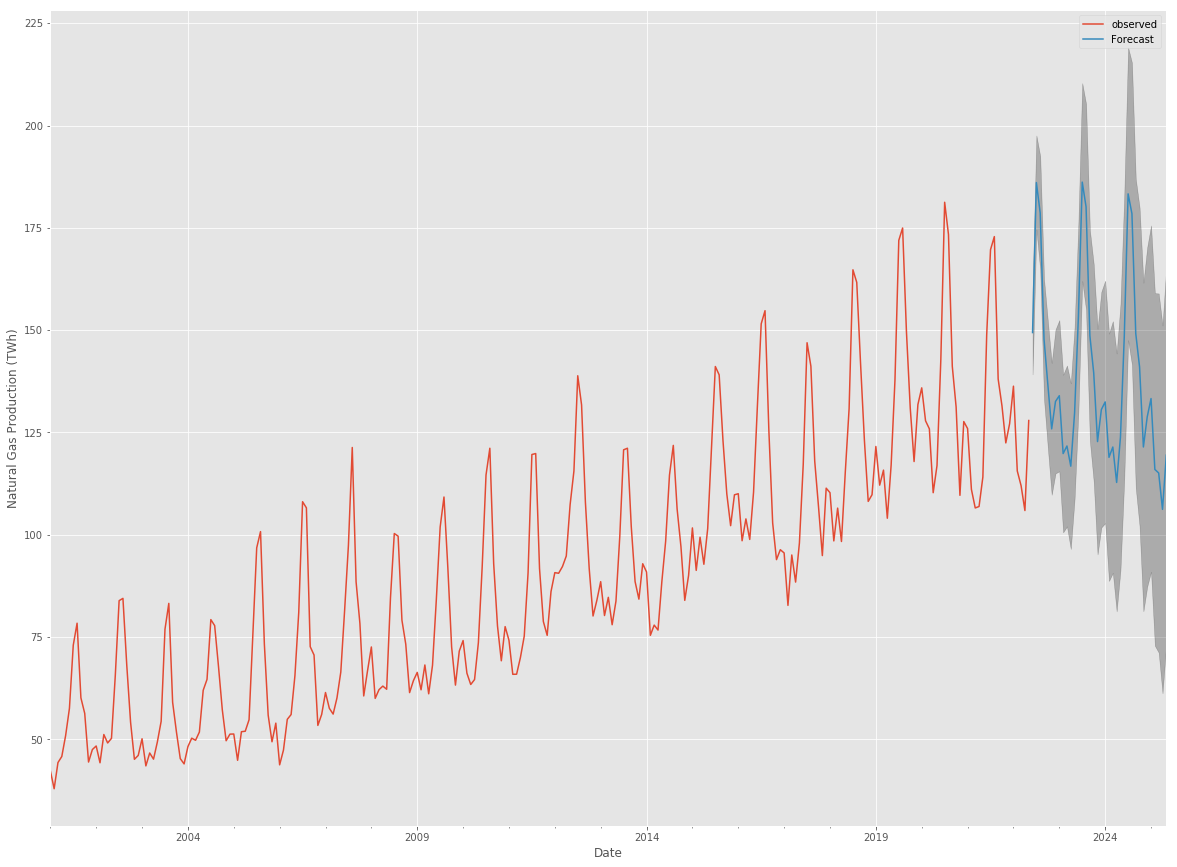

In [363]:
# Plot future predictions with confidence intervals
ax = nat.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Natural Gas Production (TWh)')

plt.legend()
plt.show()

In [366]:
prediction;

In [365]:
print(prediction.summary_frame())

Generation (TWh)        mean    mean_se  mean_ci_lower  mean_ci_upper
2022-06-01        149.416238   5.208096     139.208558     159.623918
2022-07-01        186.064605   5.865460     174.568514     197.560696
2022-08-01        178.632876   7.087491     164.741649     192.524104
2022-09-01        147.795665   7.479287     133.136532     162.454798
2022-10-01        136.694857   7.903766     121.203760     152.185955
2022-11-01        125.882831   8.212121     109.787371     141.978292
2022-12-01        132.577891   8.962937     115.010858     150.144924
2023-01-01        133.990039   9.422186     115.522893     152.457185
2023-02-01        119.849092   9.820206     100.601842     139.096342
2023-03-01        121.707044  10.030261     102.048094     141.365993
2023-04-01        116.771524  10.326148      96.532645     137.010402
2023-05-01        129.840805  10.715427     108.838954     150.842656
2023-06-01        153.382575  11.765747     130.322134     176.443015
2023-07-01        18

## Study of seasonality and states:

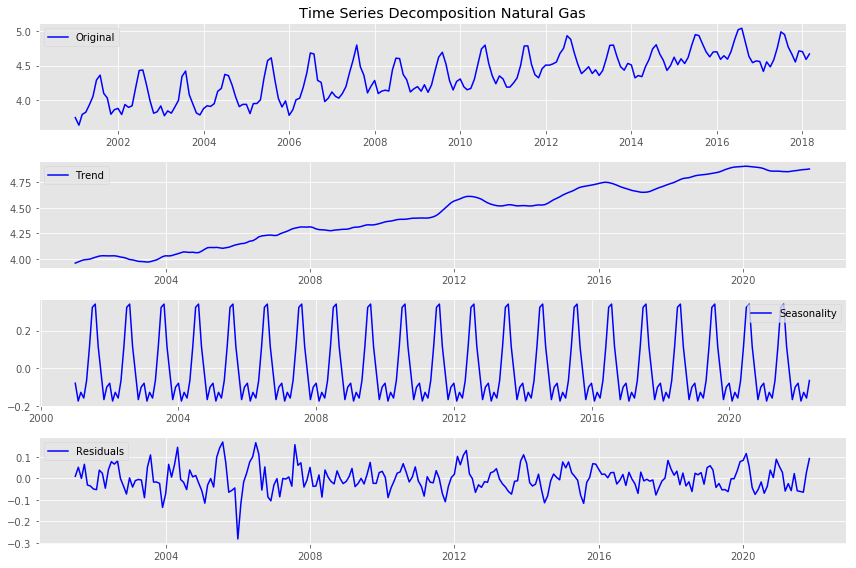

In [168]:
decomposition = seasonal_decompose(np.log(nat))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

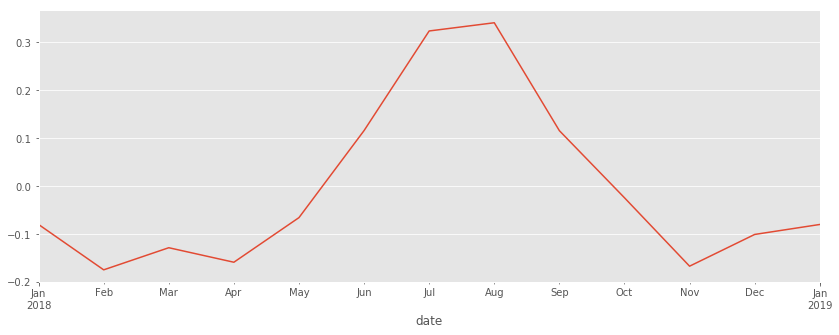

In [175]:
year=seasonal['2018-01-01':'2019-01-01']
year.plot();

In [203]:
df["Generation (TWh)"]=df["GENERATION (Megawatthours)"]/1000000
df.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)
#df

STATE                         TYPE OF PRODUCER  \
date                                                        
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
...          ...                                      ...   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   

                         ENERGY SOURCE  Generation (TWh)  
date                                                      
2001-01-01                        Coal          0.046903  
2001-01-01                   Petroleum          0.071085  
2001-01-01                 Natural Gas          0.367521  
2001-01-01  Hydroelectric Conventional          0.104549  
2001-01-01                        Wind          0.000087  
...                                ...               ...  
2022-05-01                        Coal          2.071403  
2022-05-01  Hydroelectric Conventional          0.096790  
2022-05-01                 Natural Gas          0.091570  
2022-05-01                   Petroleum          0.001812  
2022-05-01                        Wind          0.452913  

[496774 rows x 4 columns]

In [156]:
tot=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']
natgas=tot.loc[tot['ENERGY SOURCE']=='Natural Gas']


In [206]:
#natgas

In [204]:
#nat_state

In [205]:
nat_states=natgas.groupby(by=["STATE"]).sum()
nat_states.drop('US-TOTAL', axis=0, inplace=True)
#nat_states

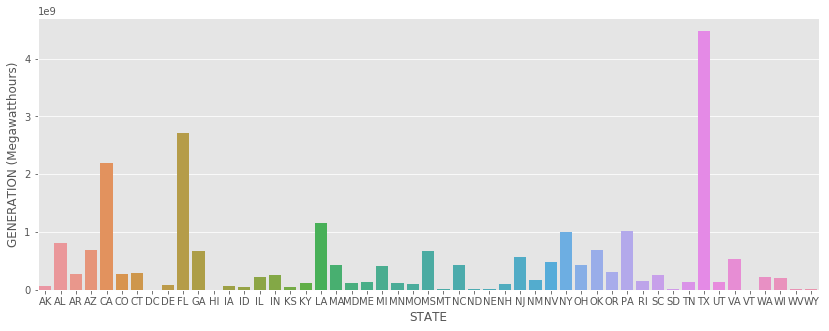

In [182]:
sns.barplot(x=nat_states.index, y=nat_state["Generation (TWh)"]);

In [183]:
top_10=nat_states.sort_values(by="Generation (TWh)", ascending=False).head(10)

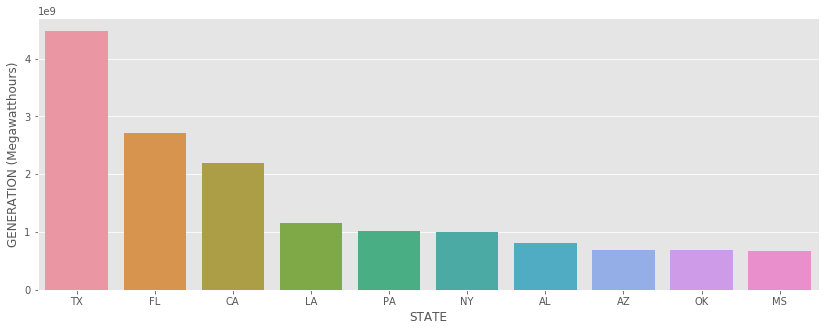

In [184]:
sns.barplot(x=top_10.index, y=top_10["Generation (TWh)"]);

In [187]:
TX=natgas.loc[natgas['STATE']=='TX']
FL=natgas.loc[natgas['STATE']=='FL']
PA=natgas.loc[natgas['STATE']=='PA']
WA=natgas.loc[natgas['STATE']=='WA']
IN=natgas.loc[natgas['STATE']=='IN']
MN=natgas.loc[natgas['STATE']=='MN']

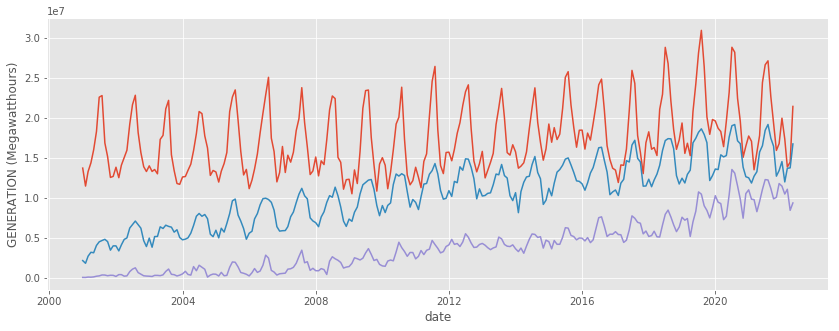

In [188]:
sns.lineplot(x=TX.index,y=TX["Generation (TWh)"])
sns.lineplot(x=FL.index,y=FL["Generation (TWh)"])
sns.lineplot(x=PA.index,y=PA["Generation (TWh)"])
plt.legend(labels=['Texas', 'Florida', 'Pennsylvania']);

In [190]:
TX

STATE               TYPE OF PRODUCER ENERGY SOURCE  \
date                                                            
2001-01-01    TX  Total Electric Power Industry   Natural Gas   
2001-02-01    TX  Total Electric Power Industry   Natural Gas   
2001-03-01    TX  Total Electric Power Industry   Natural Gas   
2001-04-01    TX  Total Electric Power Industry   Natural Gas   
2001-05-01    TX  Total Electric Power Industry   Natural Gas   
...          ...                            ...           ...   
2022-01-01    TX  Total Electric Power Industry   Natural Gas   
2022-02-01    TX  Total Electric Power Industry   Natural Gas   
2022-03-01    TX  Total Electric Power Industry   Natural Gas   
2022-04-01    TX  Total Electric Power Industry   Natural Gas   
2022-05-01    TX  Total Electric Power Industry   Natural Gas   

            GENERATION (Megawatthours)  
date                                    
2001-01-01                  13750546.0  
2001-02-01                  11507834.0  
2001-03-01                  13316335.0  
2001-04-01                  14402417.0  
2001-05-01                  16025878.0  
...                                ...  
2022-01-01                  19984717.0  
2022-02-01                  17382151.0  
2022-03-01                  13885423.0  
2022-04-01                  14501311.0  
2022-05-01                  21449423.0  

[257 rows x 4 columns]

In [ ]:
Creating Series to do seasonal decomposition

In [193]:
TXs=TX["Generation (TWh)"]
PAs=PA['GENERATION (TWh)']
WAs=WA['GENERATION (TWh)']
MNs=MN['GENERATION (TWh)']
INs=IN['GENERATION (TWh)']

In [ ]:
decomposition = seasonal_decompose(TXs)
seasonal_TX = decomposition.seasonal
yearTX=seasonal_TX['2018-01-01':'2019-01-01']

In [194]:
decomposition = seasonal_decompose(PAs)
seasonal_PA = decomposition.seasonal
yearPA=seasonal_PA['2018-01-01':'2019-01-01']

In [196]:
decomposition = seasonal_decompose(INs)
seasonal_IN = decomposition.seasonal
yearIN=seasonal_IN['2018-01-01':'2019-01-01']

In [197]:
decomposition = seasonal_decompose(WAs)
seasonal_WA = decomposition.seasonal
yearWA=seasonal_WA['2018-01-01':'2019-01-01']

In [198]:
decomposition = seasonal_decompose(MNs)
seasonal_MN = decomposition.seasonal
yearMN=seasonal_MN['2018-01-01':'2019-01-01']

In [ ]:
sns.lineplot(x=yearTX.index,y=yearTX)
sns.lineplot(x=yearPA.index,y=yearPA)
sns.lineplot(x=yearWA.index,y=yearWA)
sns.lineplot(x=yearIN.index,y=yearIN)
sns.lineplot(x=yearMN.index,y=yearMN)
plt.legend(labels=['Texas', 'Pennsylvania', 'Washington', 'Indiana', 'Minnesota']);

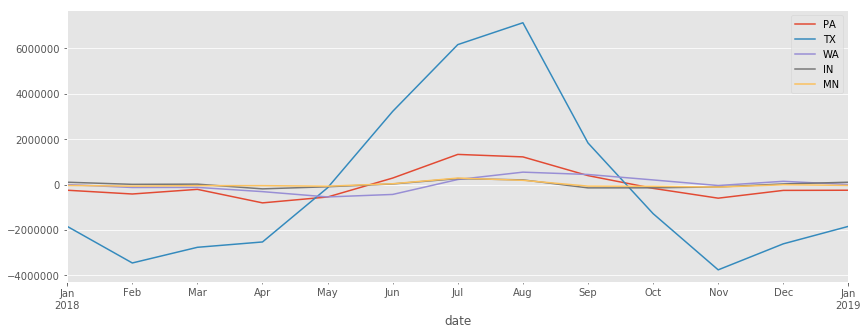

In [199]:
yearPA.plot(label='PA')
yearTX.plot(label='TX')
yearWA.plot(label='WA')
yearIN.plot(label='IN')
yearMN.plot(label='MN')

plt.legend();

### Third Grid Search SARIMAX

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 4, 8]
d = range(1,3)
q = [4]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
"""ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

In [ ]:
"""# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

In [ ]:
"""ans_df.to_pickle("./resgrid.pkl")"""

In [150]:
unpickled_df2 = pd.read_pickle("./resgrid.pkl")  
unpickled_df2.sort_values(by='aic').head(10)

pdq           pdqs   aic
1   (1, 1, 4)  (1, 2, 4, 12)  22.0
7   (1, 2, 4)  (1, 2, 4, 12)  22.0
9   (1, 2, 4)  (4, 2, 4, 12)  28.0
19  (4, 2, 4)  (1, 2, 4, 12)  28.0
13  (4, 1, 4)  (1, 2, 4, 12)  28.0
15  (4, 1, 4)  (4, 2, 4, 12)  34.0
21  (4, 2, 4)  (4, 2, 4, 12)  34.0
5   (1, 1, 4)  (8, 2, 4, 12)  36.0
10  (1, 2, 4)  (8, 1, 4, 12)  36.0
11  (1, 2, 4)  (8, 2, 4, 12)  36.0

### let me try these top 3 models:

In [153]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA2nd1 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1, 1, 4), 
                                        seasonal_order=(1, 2, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
out2nd1 = ARIMA2nd1.fit()

print(out2nd1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8517         -0       -inf      0.000       0.852       0.852
ma.L1         -1.0427         -0        inf      0.000      -1.043      -1.043
ma.L2         -0.0948   7.65e-28  -1.24e+26      0.000      -0.095      -0.095
ma.L3          0.3702   6.51e-28   5.69e+26      0.000       0.370       0.370
ma.L4         -0.0651   6.51e-28     -1e+26      0.000      -0.065      -0.065
ar.S.L12      -0.7529   1.92e-29  -3.92e+28      0.000      -0.753      -0.753
ma.S.L12   -7.702e+13   4.17e-33  -1.85e+46      0.000    -7.7e+13    -7.7e+13
ma.S.L24    2.399e+13   2.57e-41   9.35e+53      0.000     2.4e+13     2.4e+13
ma.S.L36    3.757e+13   2.04e-41   1.84e+54      0.000    3.76e+13    3.76e+13
ma.S.L48    4.524e+13   1.61e-41   2.81e+54      0.000    4.52e+13    4.52e+13
sigma2       1.58e-11   1.68e-10      0.094      0.9

In [154]:
y_hat2nd1 = out2nd1.predict(typ='levels')
RMSE_train1=np.sqrt(mean_squared_error(train, y_hat2nd1))
RMSE_train1

30.532852834952966

In [156]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA2nd2 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1, 2, 4), 
                                        seasonal_order=(1, 2, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
out2nd2 = ARIMA2nd2.fit()

print(out2nd2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0757         -0        inf      0.000      -2.076      -2.076
ma.L1          1.0308         -0       -inf      0.000       1.031       1.031
ma.L2         -2.2631         -0        inf      0.000      -2.263      -2.263
ma.L3          0.1698         -0       -inf      0.000       0.170       0.170
ma.L4          0.7020         -0       -inf      0.000       0.702       0.702
ar.S.L12      -0.8208         -0        inf      0.000      -0.821      -0.821
ma.S.L12   -1.915e+13         -0        inf      0.000   -1.92e+13   -1.92e+13
ma.S.L24     4.87e+12         -0       -inf      0.000    4.87e+12    4.87e+12
ma.S.L36     2.36e+13         -0       -inf      0.000    2.36e+13    2.36e+13
ma.S.L48    5.497e+13         -0       -inf      0.000     5.5e+13     5.5e+13
sigma2       140.6737         -0       -inf      0.0

In [157]:
y_hat2nd2 = out2nd2.predict(typ='levels')
RMSE_train2=np.sqrt(mean_squared_error(train, y_hat2nd2))
RMSE_train2

1.8683802917343876e+62

In [158]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA2nd3 = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1, 2, 4), 
                                        seasonal_order=(4, 2, 4, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
out2nd3 = ARIMA2nd3.fit()

print(out2nd3.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0757         -0        inf      0.000      -2.076      -2.076
ma.L1          1.0308         -0       -inf      0.000       1.031       1.031
ma.L2         -2.2631         -0        inf      0.000      -2.263      -2.263
ma.L3          0.1698         -0       -inf      0.000       0.170       0.170
ma.L4          0.7061         -0       -inf      0.000       0.706       0.706
ar.S.L12      -1.3602         -0        inf      0.000      -1.360      -1.360
ar.S.L24      -0.7244         -0        inf      0.000      -0.724      -0.724
ar.S.L36      -0.3907         -0        inf      0.000      -0.391      -0.391
ar.S.L48      -0.3480         -0        inf      0.000      -0.348      -0.348
ma.S.L12   -7.029e+12   9.95e-10  -7.06e+21      0.000   -7.03e+12   -7.03e+12
ma.S.L24   -5.258e+12         -0        inf      0.0

In [159]:
y_hat2nd3 = out2nd3.predict(typ='levels')
RMSE_train3=np.sqrt(mean_squared_error(train, y_hat2nd3))
RMSE_train3

1.3827667250212807e+62

In [ ]:
#Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4, 6, 8]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
"""ans2 = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

In [ ]:
"""# Find the parameters with minimal AIC value
ans2_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans2_df.loc[ans2_df['aic'].idxmin()]"""

ans2_df

In [152]:
unpickled2_df = pd.read_pickle("./resgrid2.pkl")  
unpickled2_df.sort_values(by='aic').head(10)

pdq           pdqs   aic
1   (1, 1, 4)  (1, 2, 4, 12)  22.0
7   (1, 2, 4)  (1, 2, 4, 12)  22.0
13  (4, 1, 4)  (1, 2, 4, 12)  28.0
19  (4, 2, 4)  (1, 2, 4, 12)  28.0
9   (1, 2, 4)  (4, 2, 4, 12)  28.0
21  (4, 2, 4)  (4, 2, 4, 12)  34.0
15  (4, 1, 4)  (4, 2, 4, 12)  34.0
11  (1, 2, 4)  (8, 2, 4, 12)  36.0
5   (1, 1, 4)  (8, 2, 4, 12)  36.0
10  (1, 2, 4)  (8, 1, 4, 12)  36.0

In [ ]:
unpickled2_df.isna().sum()

In [ ]:
unpickled2_df.loc[unpickled2_df['aic'].idxmin()]